# Fraud detection EDA

In [2]:
# !pip install pygwalker

### Import Libraries

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [4]:
plt.style.use("fivethirtyeight")

In [5]:
# Set theme for all charts in the notebook for both matplotlib and seaborn
# sns.set_theme()

### Read Data

In [6]:
def read_data():
    requests_data = pd.read_csv("data/requests.csv")
    device_data = pd.read_csv("data/device_info.csv")

    # Joining datasets
    df = pd.merge(requests_data, device_data, on='accountid', how='left')
    return df

In [7]:
def handle_nulls(df):
    # Distribution of records containing null with respect to target variable. 
    # Since most are normal transactions, we can impute with median (most features have outliers).
    
    float_cols = df.select_dtypes(include='float').columns
    col_median = df[float_cols].median()
    df[float_cols] = df[float_cols].fillna(col_median)
    
    bool_cols = df.select_dtypes(include='bool').columns
    col_mode = df[bool_cols].mode()
    df[bool_cols] = df[bool_cols].fillna(col_mode)
    
    # Encode null device features as a separate category
    df['device_feat_1'].fillna('unknown', inplace=True)
    df['device_feat_2'].fillna('unknown', inplace=True)

    return df

In [8]:
def clean_data(df):
    df.drop_duplicates(inplace=True)
    df.drop(['count_feat_16','count_feat_17'], axis=1, inplace=True)
    cols_dtype_clean = ['anomaly_feat_0', 'anomaly_feat_1', 'anomaly_feat_2', 'interaction_feat_0']
    df[cols_dtype_clean] = df[cols_dtype_clean].astype('bool')

    df.loc[df['count_feat_13']==12130802.0, 'count_feat_13'] = np.nan
    df.loc[df['count_feat_14']==12130802.0, 'count_feat_14'] = np.nan
    df.loc[df['count_feat_15']==12130802.0, 'count_feat_15'] = np.nan
    
    # Encode boolean values to integers
    bool_cols = df.select_dtypes(include='bool').columns
    df[bool_cols] = df[bool_cols].replace({True:1, False:0})
    return df

In [10]:
from category_encoders import BinaryEncoder
from sklearn.preprocessing import RobustScaler, StandardScaler

def make_dataset(df, drop_corr_cols=False, encoding=False, normalize=False, scaler='std'):
    if drop_corr_cols:
        df = df.drop(['count_feat_3', 'count_feat_8', 'count_feat_12', 
                      'count_feat_11', 'count_feat_14', 'count_feat_15', 
                      'anomaly_feat_2', 'interaction_feat_1'], axis=1)
        
    if encoding:
        # Encoding categorial variables using binary encoder
        encoder=BinaryEncoder(cols=['device_feat_1', 'device_feat_2'])
        encoded_df = encoder.fit_transform(df[['device_feat_1', 'device_feat_2']])
        df = pd.concat([df, encoded_df], axis=1).drop(['device_feat_1', 'device_feat_2'], axis=1)
        
    if normalize:
        # Scale numerical features
        if scaler=='std':
            scaler = StandardScaler()
        elif scaler=='robust':
            scaler = RobustScaler()
        df_num_cols = df.select_dtypes(include='float')
        scaled_df = scaler.fit_transform(df_num_cols.drop('is_attack', axis=1))
        scaled_df = pd.DataFrame(scaled_df, columns=df_num_cols.drop('is_attack', axis=1).columns)
        df = pd.concat([scaled_df, df.select_dtypes(exclude='float')], axis=1)
    return df

In [11]:
df = read_data()
df = clean_data(df)

In [92]:
# df_no_null = handle_nulls(df)

In [13]:
dff = make_dataset(df, drop_corr_cols=False, encoding=False, normalize=False)

In [14]:
dff

anomaly_feat_0  anomaly_feat_1  anomaly_feat_2  anomaly_feat_3  \
0                   1               0               0               0   
1                   0               0               0               0   
2                   0               0               0               0   
3                   0               0               0               0   
4                   0               0               0               0   
...               ...             ...             ...             ...   
30007               0               0               0               0   
30008               0               0               0               0   
30009               0               0               0               0   
30010               0               0               0               0   
30011               0               0               0               0   

       count_feat_0  count_feat_1  count_feat_2  count_feat_3  count_feat_4  \
0               0.0           0.0          0.00           0.0           0.0   
1               0.0           0.0          0.00           0.0           0.0   
2               0.0           0.0          0.00           0.0           0.0   
3               0.0           0.0          0.00           0.0           0.0   
4               0.0           4.0          0.25           3.0           4.0   
...             ...           ...           ...           ...           ...   
30007           0.0           0.0          0.00           0.0           0.0   
30008           0.0           0.0          0.00           0.0           0.0   
30009           0.0           3.0          0.00           2.0           0.0   
30010           0.0           0.0          0.00           0.0           0.0   
30011           0.0           0.0          0.00           0.0           0.0   

       count_feat_5  ...  count_feat_15  interaction_feat_0  \
0               0.0  ...            0.0                   1   
1              32.0  ...            0.0                   1   
2               2.0  ...            0.0                   1   
3               2.0  ...            0.0                   1   
4               0.0  ...            4.0                   1   
...             ...  ...            ...                 ...   
30007           0.0  ...            0.0                   0   
30008           3.0  ...            0.0                   1   
30009           0.0  ...            0.0                   1   
30010           1.0  ...            0.0                   1   
30011           0.0  ...            0.0                   1   

       interaction_feat_1  interaction_feat_2  interaction_feat_3  timestamp  \
0                       0                 0.0                 0.0       3567   
1                       0                 0.0                 0.0      24579   
2                       0                 0.0                 0.0       7920   
3                       0                 0.0                 0.0        704   
4                       0                 3.0                 0.0      27135   
...                   ...                 ...                 ...        ...   
30007                   1                 0.0                 0.0      18020   
30008                   0                 1.0                 0.0      26314   
30009                   0                 0.0                 0.0      28232   
30010                   0                 0.0                 1.0        933   
30011                   0                 0.0                 0.0       3622   

       is_attack                             accountid  device_feat_1  \
0              0  4d44d091-74e6-4bb4-a76f-65b73e909544     browser_16   
1              0  8af0f198-7b3d-4e00-8941-891954901e1f     browser_16   
2              0  2172f57c-df31-48eb-ab18-297dbe294534            NaN   
3              0  fd0d7177-f955-423b-b273-922581fe0f46            NaN   
4              0  5e9956d1-5328-4c2a-b058-7d3d78ed45da            NaN   
...          ...         

### EDA

In [15]:
# len(requests_data), len(device_data)

In [16]:
df.describe().T

count          mean          std  min      25%      50%  \
anomaly_feat_0      29973.0      0.153305     0.360287  0.0     0.00      0.0   
anomaly_feat_1      29973.0      0.071865     0.258268  0.0     0.00      0.0   
anomaly_feat_2      29973.0      0.062690     0.242408  0.0     0.00      0.0   
anomaly_feat_3      29973.0      0.093084     0.290555  0.0     0.00      0.0   
count_feat_0        29969.0      6.813441    45.285837  0.0     0.00      0.0   
count_feat_1        29969.0      0.611899     1.858633  0.0     0.00      0.0   
count_feat_2        29948.0      0.065401     1.863566  0.0     0.00      0.0   
count_feat_3        29967.0      6.839390    44.656045  0.0     0.00      0.0   
count_feat_4        29948.0      0.181682     1.565208  0.0     0.00      0.0   
count_feat_5        29961.0     38.171924   260.792168  0.0     0.00      0.0   
count_feat_6        29796.0   6479.241811  6325.166226  0.0  1022.00   4042.5   
count_feat_7        29796.0   3340.313498  3219.991421  0.0   375.75   2384.0   
count_feat_8        29969.0     15.820982    82.578952  0.0     0.00      0.0   
count_feat_9        29946.0      1.274694    11.145523  0.0     0.00      0.0   
count_feat_10       29946.0      8.630969    65.305397  0.0     0.00      0.0   
count_feat_11       29948.0     10.228129    70.244031  0.0     0.00      0.0   
count_feat_12       29969.0      7.429811    45.698664  0.0     0.00      0.0   
count_feat_13       29945.0      0.140424     5.677387  0.0     0.00      0.0   
count_feat_14       29945.0      0.139422     5.831418  0.0     0.00      0.0   
count_feat_15       29947.0      0.202925     2.079337  0.0     0.00      0.0   
interaction_feat_0  29973.0      0.789210     0.407876  0.0     1.00      1.0   
interaction_feat_1  29973.0      0.210790     0.407876  0.0     0.00      0.0   
interaction_feat_2  29954.0      0.804333     4.043095  0.0     0.00      0.0   
interaction_feat_3  29954.0      0.134473     0.600313  0.0     0.00      0.0   
timestamp           29973.0  14760.235012  8506.887695  0.0  7390.00  14765.0   
is_attack           29973.0      0.097488     0.296626  0.0     0.00      0.0   

                         75%      max  
anomaly_feat_0          0.00      1.0  
anomaly_feat_1          0.00      1.0  
anomaly_feat_2          0.00      1.0  
anomaly_feat_3          0.00      1.0  
count_feat_0            0.00    432.0  
count_feat_1            0.00     52.0  
count_feat_2            0.00    293.0  
count_feat_3            0.00    426.0  
count_feat_4            0.00    183.0  
count_feat_5            8.00   4824.0  
count_feat_6        10298.00  22446.0  
count_feat_7         5429.25  13516.0  
count_feat_8            2.00    951.0  
count_feat_9            0.00    933.0  
count_feat_10           0.00   1568.0  
count_feat_11           2.00   1604.0  
count_feat_12           1.00    434.0  
count_feat_13           0.00    642.0  
count_feat_14           0.00    642.0  
count_feat_15           0.00    249.0  
interaction_feat_0      1.00      1.0  
interaction_feat_1      0.00      1.0  
interaction_feat_2      0.00    329.0  
interaction_feat_3      0.00     32.0  
timestamp           22133.00  29466.0  
is_attack               0.00      1.0

In [17]:
#Percentage of nulls by column
pd.DataFrame(df.isnull().sum()/len(df)*100, columns=['per_null']).sort_values(by='per_null', ascending=False)

per_null
device_feat_2       30.277250
device_feat_1       30.277250
count_feat_6         0.590531
count_feat_7         0.590531
count_feat_14        0.093417
count_feat_13        0.093417
count_feat_9         0.090081
count_feat_10        0.090081
count_feat_15        0.086745
count_feat_4         0.083408
count_feat_2         0.083408
count_feat_11        0.083408
interaction_feat_2   0.063390
interaction_feat_3   0.063390
count_feat_5         0.040036
count_feat_3         0.020018
count_feat_8         0.013345
count_feat_1         0.013345
count_feat_12        0.013345
count_feat_0         0.013345
timestamp            0.000000
anomaly_feat_2       0.000000
accountid            0.000000
is_attack            0.000000
anomaly_feat_3       0.000000
interaction_feat_1   0.000000
interaction_feat_0   0.000000
anomaly_feat_1       0.000000
anomaly_feat_0       0.000000

In [18]:
df_dup = df.groupby(['timestamp', 'accountid']).size().reset_index(name='count').sort_values(by='count', ascending=False)
df_dup[df_dup['count']>1].sort_values('accountid')

timestamp                             accountid  count
8012        7897  83d3e851-9f34-43d6-b810-14413e93a6df      2
20289      19987  a9d4977e-df76-44fc-8bd0-427f4d3f8366      2

In [20]:
dff[dff['accountid']=='83d3e851-9f34-43d6-b810-14413e93a6df'].T

4949   \
anomaly_feat_0                                         0   
anomaly_feat_1                                         0   
anomaly_feat_2                                         0   
anomaly_feat_3                                         0   
count_feat_0                                         0.0   
count_feat_1                                         4.0   
count_feat_2                                        0.25   
count_feat_3                                         3.0   
count_feat_4                                         4.0   
count_feat_5                                         8.0   
count_feat_6                                      3843.0   
count_feat_7                                      1875.0   
count_feat_8                                         4.0   
count_feat_9                                         0.0   
count_feat_10                                        0.0   
count_feat_11                                        4.0   
count_feat_12                                        4.0   
count_feat_13                                        0.0   
count_feat_14                                        0.0   
count_feat_15                                        4.0   
interaction_feat_0                                     0   
interaction_feat_1                                     1   
interaction_feat_2                                   0.0   
interaction_feat_3                                   0.0   
timestamp                                           7897   
is_attack                                              0   
accountid           83d3e851-9f34-43d6-b810-14413e93a6df   
device_feat_1                                        NaN   
device_feat_2                                        NaN   

                                                   14045  
anomaly_feat_0                                         0  
anomaly_feat_1                                         0  
anomaly_feat_2                                         0  
anomaly_feat_3                                         0  
count_feat_0                                         0.0  
count_feat_1                                         4.0  
count_feat_2                                        0.25  
count_feat_3                                         3.0  
count_feat_4                                         4.0  
count_feat_5                                         8.0  
count_feat_6                                      3843.0  
count_feat_7                                      1875.0  
count_feat_8                                         4.0  
count_feat_9                                         0.0  
count_feat_10                                        0.0  
count_feat_11                                        4.0  
count_feat_12                                        4.0  
count_feat_13                                        0.0  
count_feat_14                                        0.0  
count_feat_15                                        4.0  
interaction_feat_0                                     1  
interaction_feat_1                                     0  
interaction_feat_2                                   4.0  
interaction_feat_3                                   0.0  
timestamp                                           7897  
is_attack                                              0  
accountid           83d3e851-9f34-43d6-b810-14413e93a6df  
device_feat_1                                        NaN  
device_feat_2                                        NaN

In [21]:
dff[dff['accountid']=='a9d4977e-df76-44fc-8bd0-427f4d3f8366'].T

10208  \
anomaly_feat_0                                         0   
anomaly_feat_1                                         0   
anomaly_feat_2                                         0   
anomaly_feat_3                                         1   
count_feat_0                                         0.0   
count_feat_1                                        24.0   
count_feat_2                                         0.0   
count_feat_3                                        23.0   
count_feat_4                                         0.0   
count_feat_5                                        78.0   
count_feat_6                                        92.0   
count_feat_7                                        54.0   
count_feat_8                                        55.0   
count_feat_9                                         0.0   
count_feat_10                                        0.0   
count_feat_11                                        0.0   
count_feat_12                                       24.0   
count_feat_13                                        0.0   
count_feat_14                                        0.0   
count_feat_15                                        0.0   
interaction_feat_0                                     0   
interaction_feat_1                                     1   
interaction_feat_2                                   0.0   
interaction_feat_3                                   0.0   
timestamp                                          19987   
is_attack                                              0   
accountid           a9d4977e-df76-44fc-8bd0-427f4d3f8366   
device_feat_1                                        NaN   
device_feat_2                                        NaN   

                                                   13734  \
anomaly_feat_0                                         0   
anomaly_feat_1                                         0   
anomaly_feat_2                                         0   
anomaly_feat_3                                         0   
count_feat_0                                         0.0   
count_feat_1                                        24.0   
count_feat_2                                        0.05   
count_feat_3                                        23.0   
count_feat_4                                        20.0   
count_feat_5                                        78.0   
count_feat_6                                        92.0   
count_feat_7                                        54.0   
count_feat_8                                        55.0   
count_feat_9                                         0.0   
count_feat_10                                        0.0   
count_feat_11                                       50.0   
count_feat_12                                       24.0   
count_feat_13                                        0.0   
count_feat_14                                        0.0   
count_feat_15                                       20.0   
interaction_feat_0                                     0   
interaction_feat_1                                     1   
interaction_feat_2                                   0.0   
interaction_feat_3                                   0.0   
timestamp                                          19987   
is_attack                                              1   
accountid           a9d4977e-df76-44fc-8bd0-427f4d3f8366   
device_feat_1                                        NaN   
device_feat_2                                        NaN   

                                                   23511  \
anomaly_feat_0                                         0   
anomaly_feat_1                                         0   
anomaly_feat_2                                         0   
anomaly_feat_3                                         0   
count_feat_0                                         0.0   
count_feat_1                                         5.0   
count_feat_2                 

In [14]:
df.dtypes

anomaly_feat_0           bool
anomaly_feat_1           bool
anomaly_feat_2           bool
anomaly_feat_3           bool
count_feat_0          float64
count_feat_1          float64
count_feat_2          float64
count_feat_3          float64
count_feat_4          float64
count_feat_5          float64
count_feat_6          float64
count_feat_7          float64
count_feat_8          float64
count_feat_9          float64
count_feat_10         float64
count_feat_11         float64
count_feat_12         float64
count_feat_13         float64
count_feat_14         float64
count_feat_15         float64
interaction_feat_0       bool
interaction_feat_1       bool
interaction_feat_2    float64
interaction_feat_3    float64
timestamp               int64
is_attack                bool
accountid              object
device_feat_1          object
device_feat_2          object
dtype: object

<Axes: >

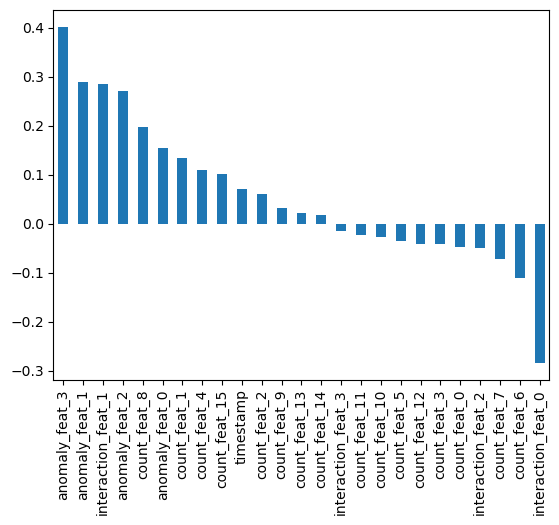

In [12]:
# Plotting feature correlations with the target variable
df.corr(numeric_only=True)['is_attack'].sort_values(ascending=False).drop('is_attack').plot(kind='bar')

Text(0.5, 1.0, 'Correlation analysis')

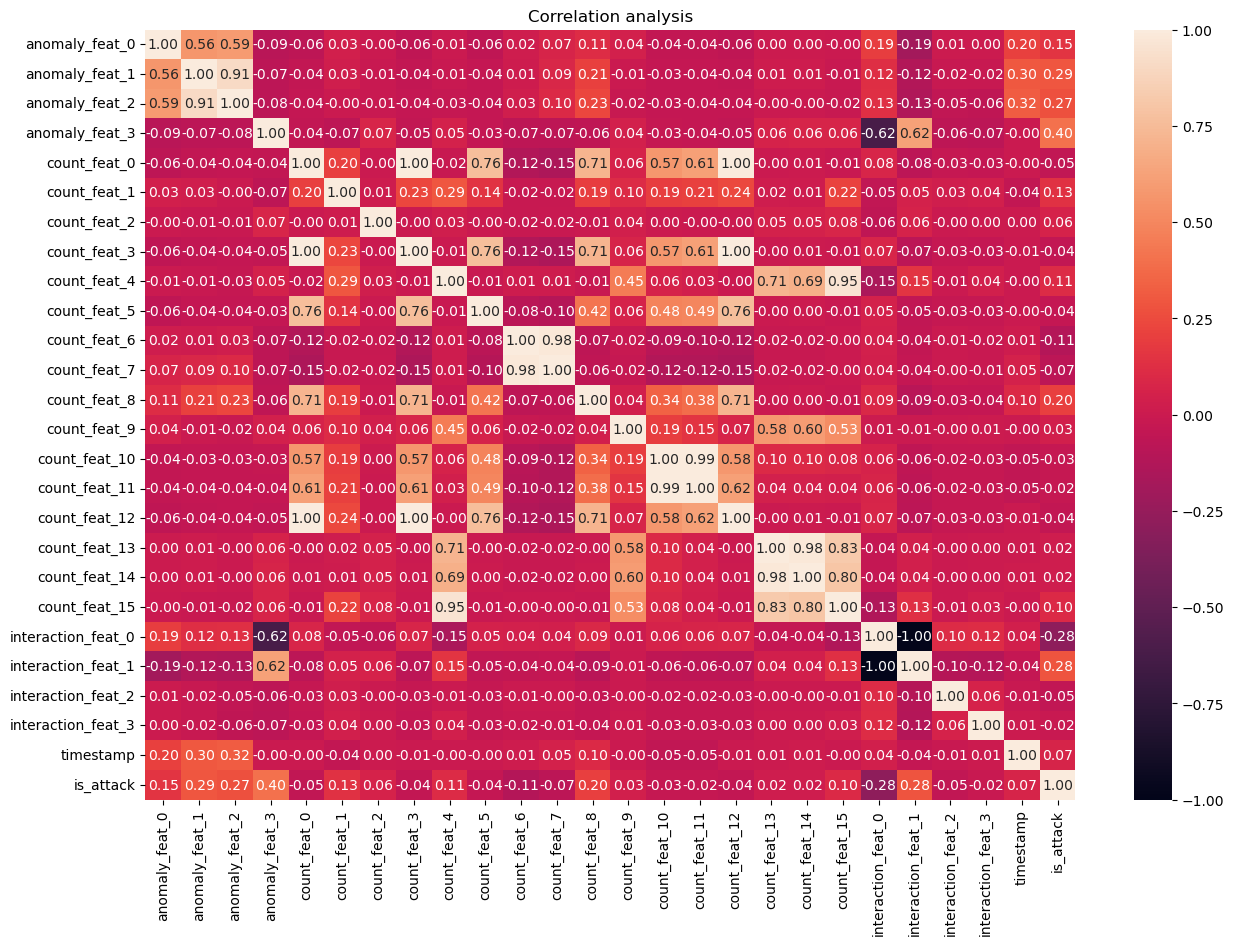

In [16]:
plt.figure(figsize=(15,10))
sns.heatmap(df.corr(numeric_only=True), annot=True, fmt=".2f")
plt.title('Correlation analysis')

'count_feat_0', 'count_feat_3' and 'count_feat_12' - 1

'count_feat_4' and 'count_feat_15' - 0.95 - Keep

'count_feat_7' and 'count_feat_8' - 0.98

'count_feat_11' and 'count_feat_10' - 0.99

'count_feat_14' and 'count_feat_13' - 0.98

'anomaly_feat_1' and 'anomaly_feat_2' - 0.91 - - Keep

'interaction_feat_1' and 'interaction_feat_0' - -1

In [17]:
# df = df.drop(['count_feat_3', 'count_feat_8', 'count_feat_12', 'count_feat_11', 'count_feat_14', 'count_feat_15', 'anomaly_feat_2', 'interaction_feat_1'], axis=1)

In [18]:
#sns.scatterplot(df, x='count_feat_3', y='count_feat_12')

In [19]:
#sns.scatterplot(df, x='count_feat_7', y='count_feat_8', hue='is_attack')

In [20]:
# df['log_count_feat_7'] = np.log(df['count_feat_7'])
# df['log_count_feat_8'] = np.log(df['count_feat_8'])
# sns.scatterplot(df, x='log_count_feat_7', y='log_count_feat_8', hue='is_attack')

In [21]:
# sns.displot(df, x='count_feat_0', hue='is_attack', col='is_attack', kde=True)

In [22]:
num_cols = dff.select_dtypes('float64')

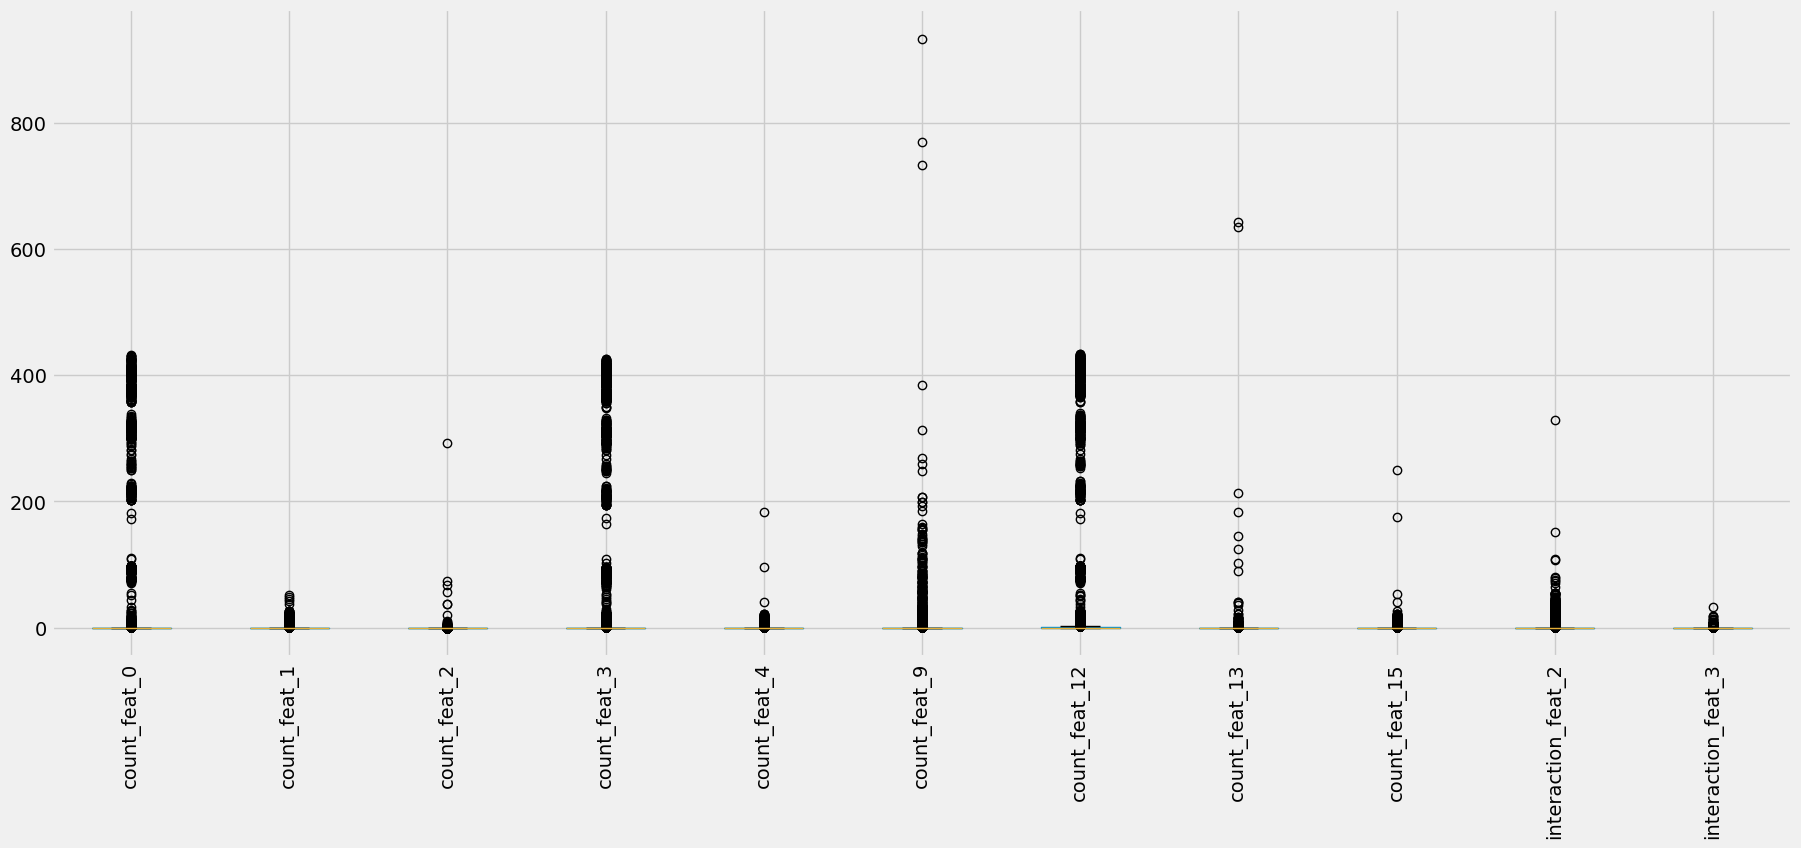

In [28]:
plt.figure(figsize=(20,8))
num_cols.drop(['count_feat_5','count_feat_6', 'count_feat_7', 'count_feat_10', 'count_feat_11', 'count_feat_8', 'count_feat_14'], axis=1).boxplot()
plt.xticks(rotation=90)
plt.show()

In [24]:
#sns.pairplot(df[df.dtypes], hue='is_attack')

In [14]:
len(df.select_dtypes(include='float').columns)

18

<Figure size 300x200 with 0 Axes>

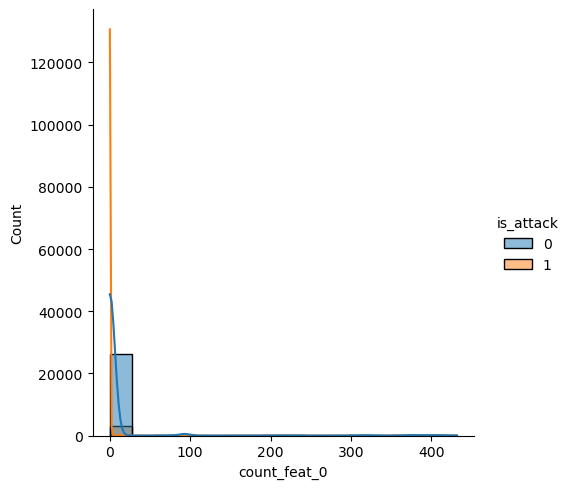

<Figure size 300x200 with 0 Axes>

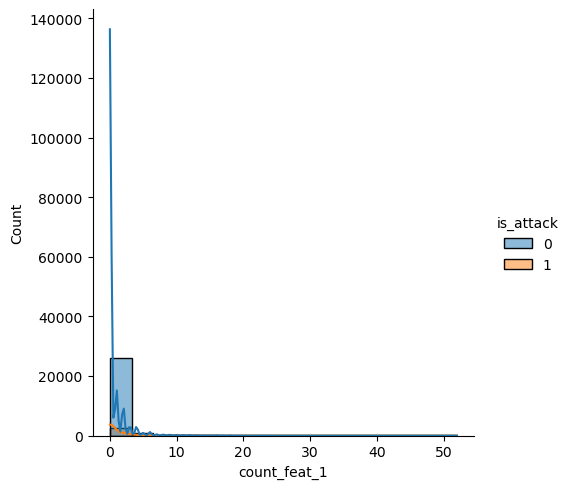

<Figure size 300x200 with 0 Axes>

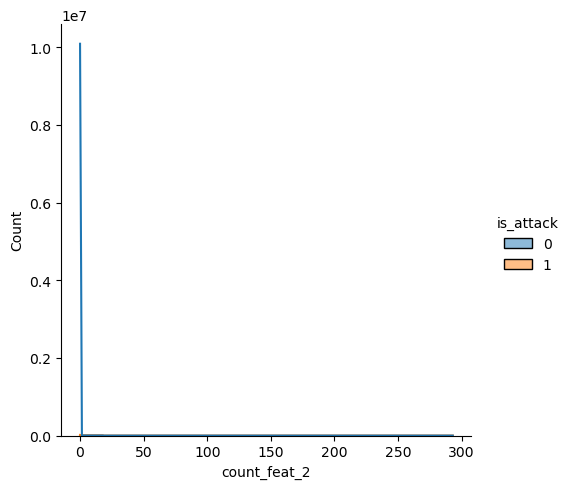

<Figure size 300x200 with 0 Axes>

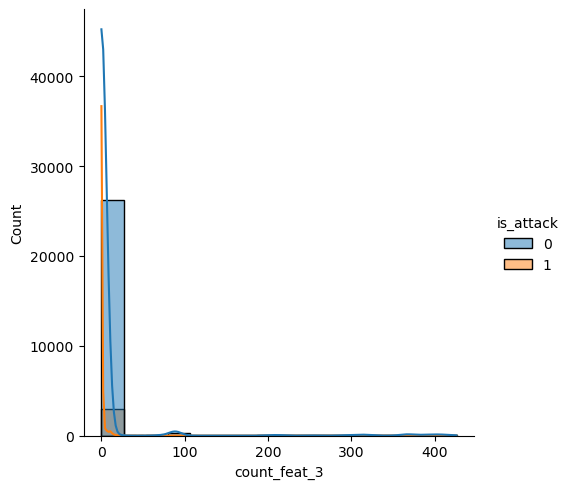

<Figure size 300x200 with 0 Axes>

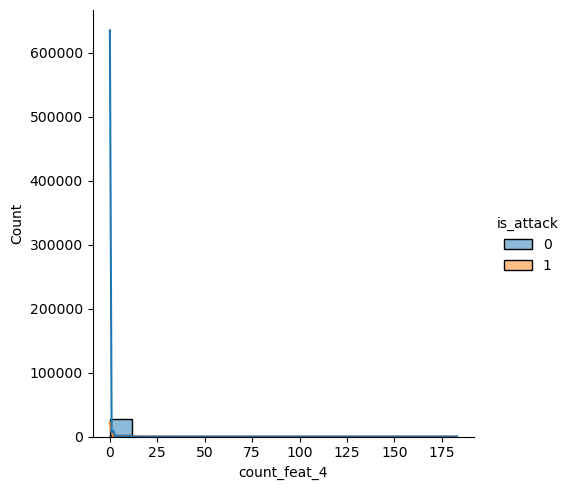

<Figure size 300x200 with 0 Axes>

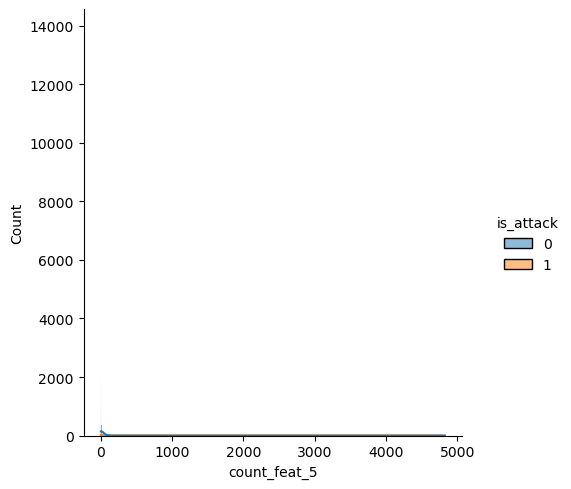

<Figure size 300x200 with 0 Axes>

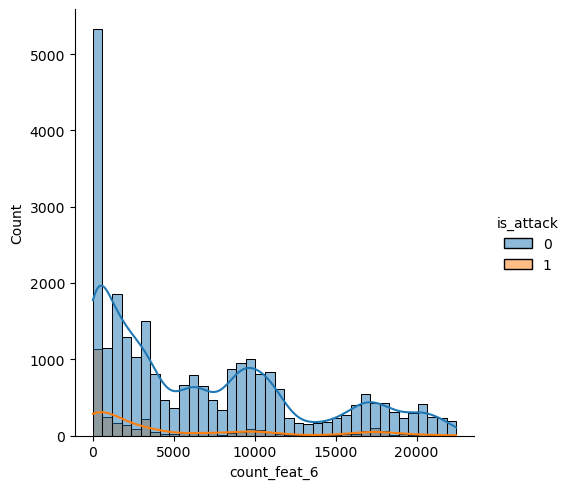

<Figure size 300x200 with 0 Axes>

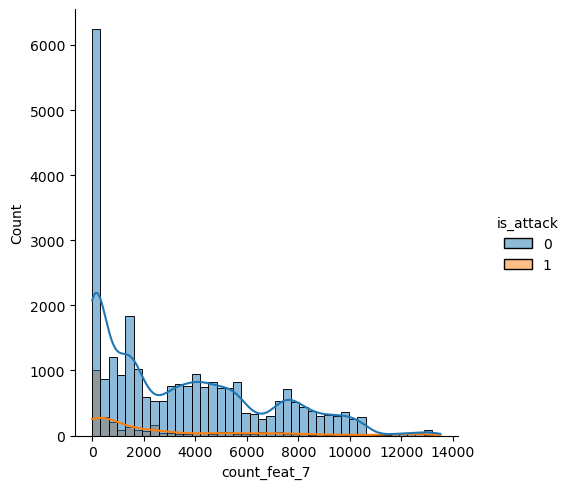

<Figure size 300x200 with 0 Axes>

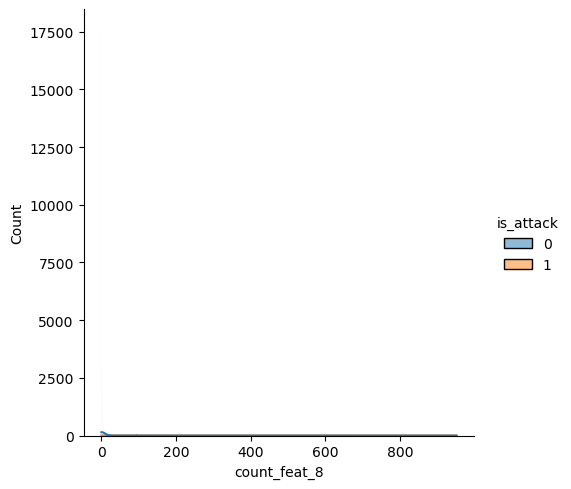

<Figure size 300x200 with 0 Axes>

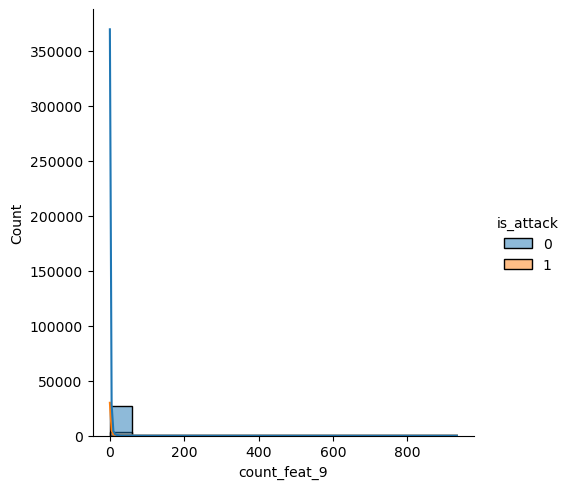

<Figure size 300x200 with 0 Axes>

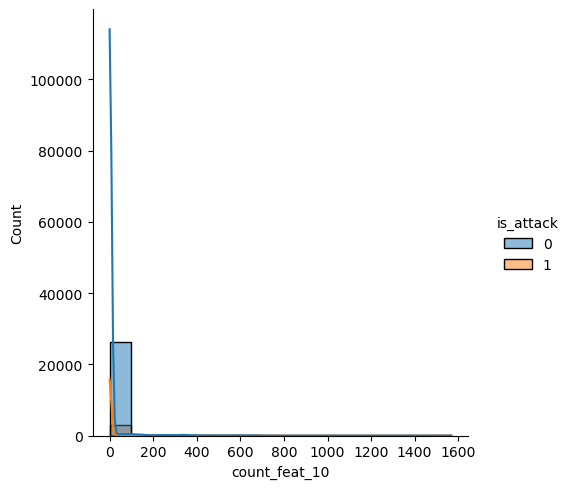

<Figure size 300x200 with 0 Axes>

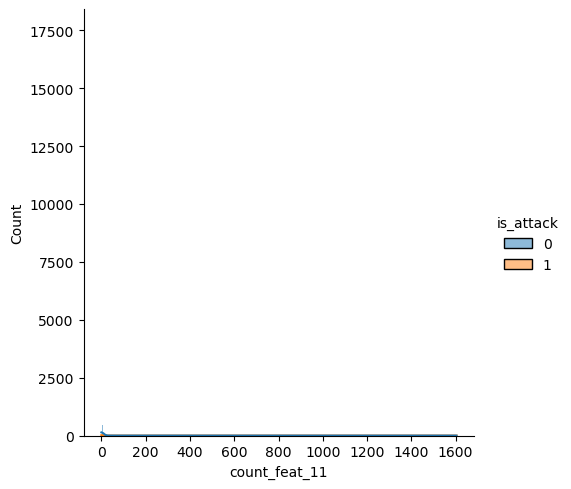

<Figure size 300x200 with 0 Axes>

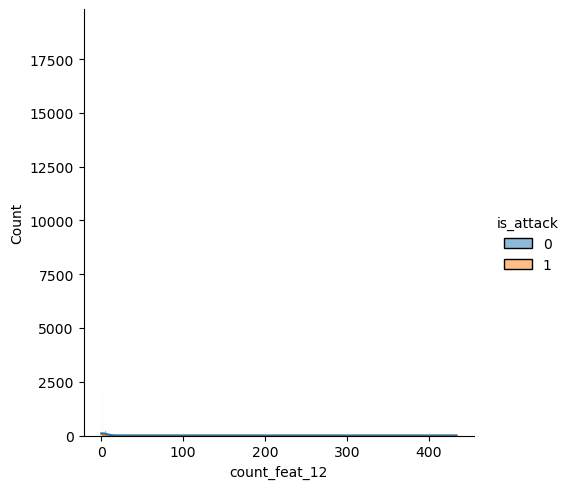

<Figure size 300x200 with 0 Axes>

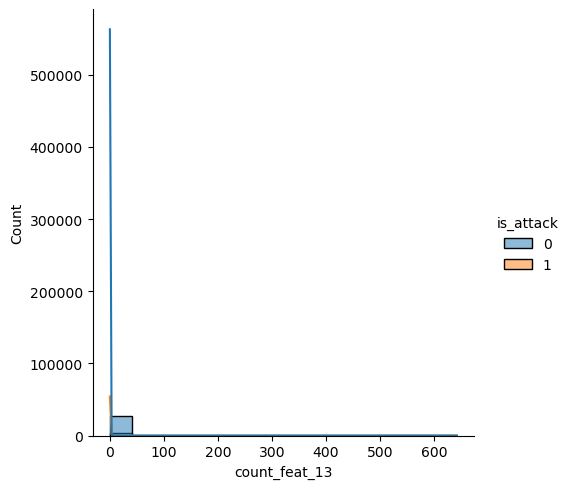

<Figure size 300x200 with 0 Axes>

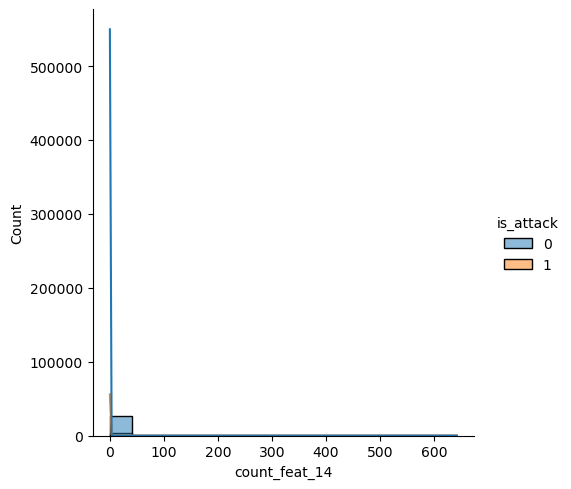

<Figure size 300x200 with 0 Axes>

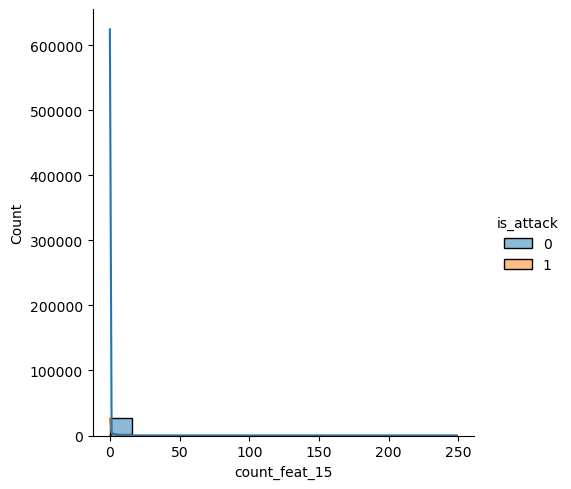

<Figure size 300x200 with 0 Axes>

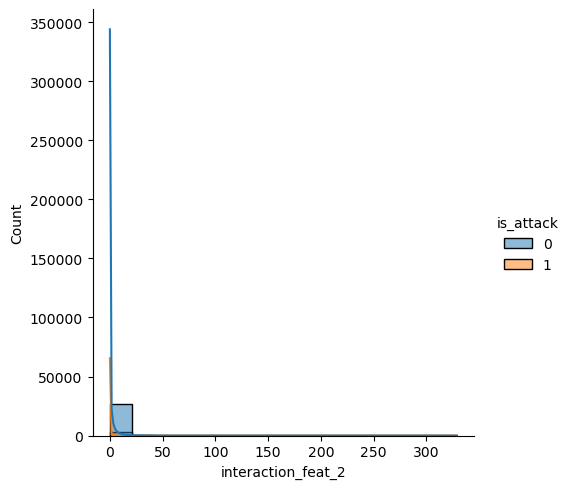

<Figure size 300x200 with 0 Axes>

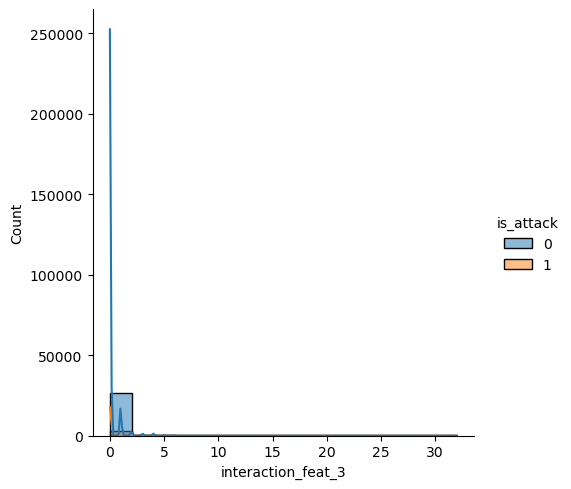

In [16]:
# Plot feature distributions
for feature in df.select_dtypes(include='float').columns:
    plt.figure(figsize=(3,2))
    sns.displot(df, x=feature, hue='is_attack', kde=True)
    plt.show()

In [31]:
df1 = handle_nulls(df)

In [39]:
# Log tranformation to handle skew
df1['count_feat_0_log'] = np.log(df['count_feat_0']+1)

In [40]:
df1.count_feat_0_log.value_counts()

0.000000    26352
0.693147     1961
1.098612      489
1.386294      180
4.532599       73
            ...  
4.304065        1
5.793014        1
6.061457        1
3.970292        1
5.891644        1
Name: count_feat_0_log, Length: 206, dtype: int64

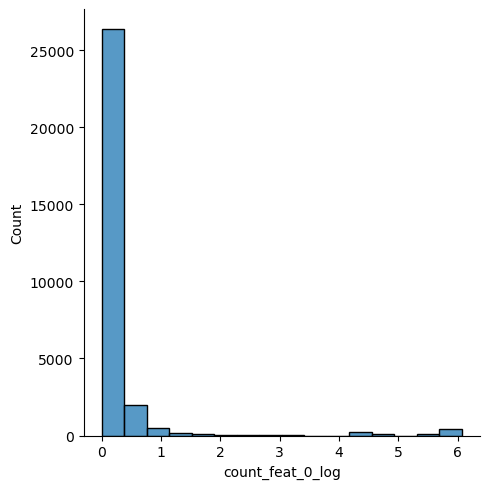

In [41]:
sns.displot(df1, x='count_feat_0_log')

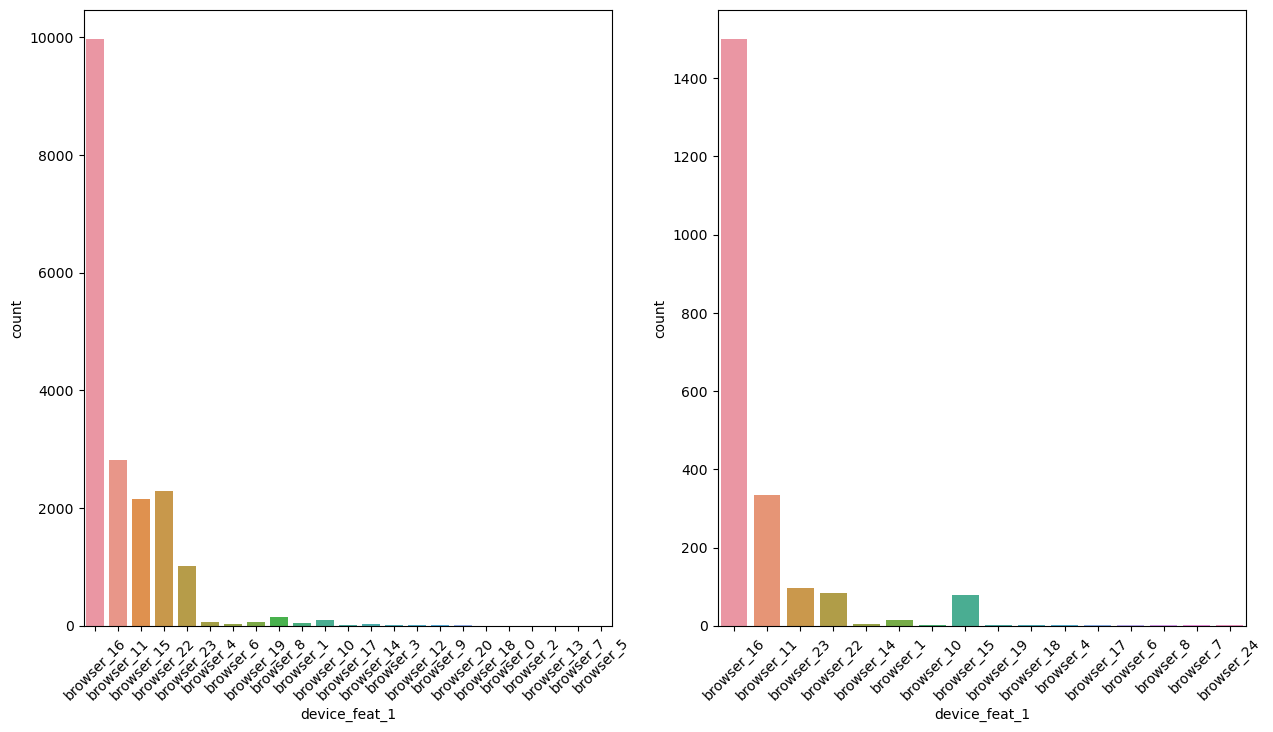

In [26]:
plt.figure(figsize=(15,8))
plt.subplot(1,2,1)
sns.countplot(df[df['is_attack']==0], x='device_feat_1')
plt.xticks(rotation=45)

plt.subplot(1,2,2)
sns.countplot(df[df['is_attack']==1], x='device_feat_1')
plt.xticks(rotation=45)
plt.show()

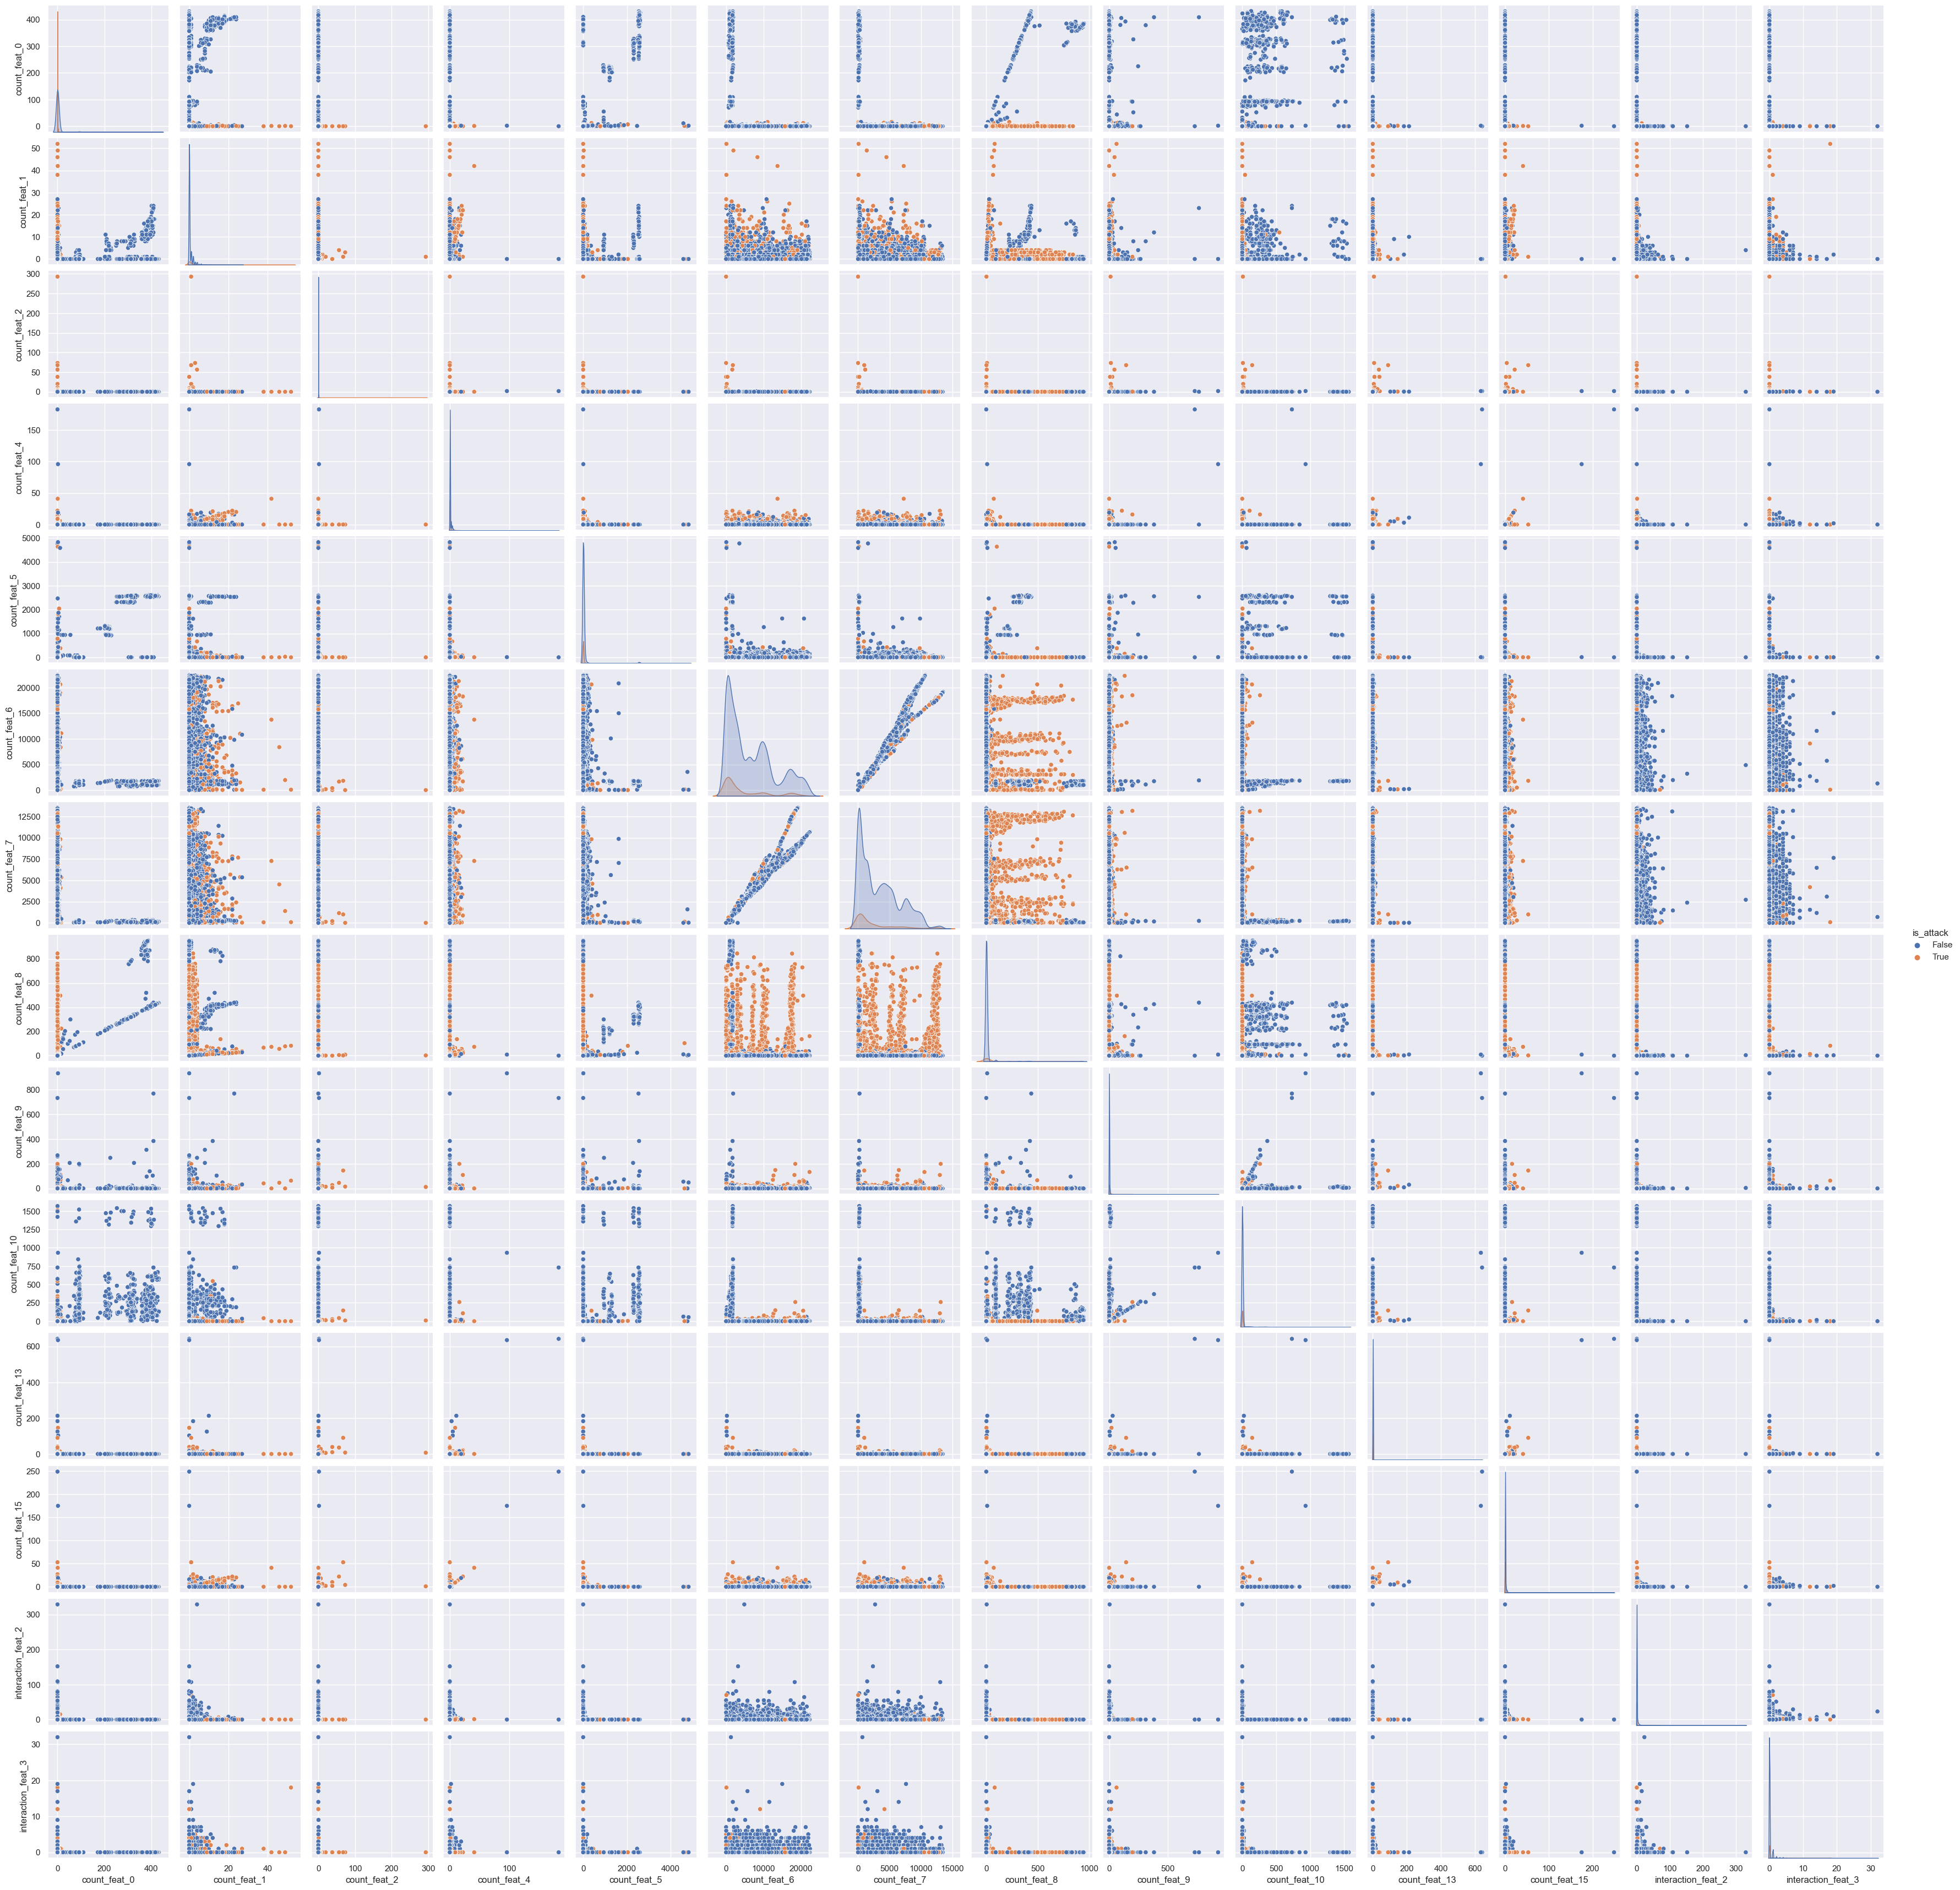

In [285]:
num_cols['is_attack'] = df['is_attack']
sns.pairplot(num_cols, hue='is_attack')

In [43]:
df

anomaly_feat_0  anomaly_feat_1  anomaly_feat_2  anomaly_feat_3  \
0                   1               0               0               0   
1                   0               0               0               0   
2                   0               0               0               0   
3                   0               0               0               0   
4                   0               0               0               0   
...               ...             ...             ...             ...   
30007               0               0               0               0   
30008               0               0               0               0   
30009               0               0               0               0   
30010               0               0               0               0   
30011               0               0               0               0   

       count_feat_0  count_feat_1  count_feat_2  count_feat_3  count_feat_4  \
0               0.0           0.0          0.00           0.0           0.0   
1               0.0           0.0          0.00           0.0           0.0   
2               0.0           0.0          0.00           0.0           0.0   
3               0.0           0.0          0.00           0.0           0.0   
4               0.0           4.0          0.25           3.0           4.0   
...             ...           ...           ...           ...           ...   
30007           0.0           0.0          0.00           0.0           0.0   
30008           0.0           0.0          0.00           0.0           0.0   
30009           0.0           3.0          0.00           2.0           0.0   
30010           0.0           0.0          0.00           0.0           0.0   
30011           0.0           0.0          0.00           0.0           0.0   

       count_feat_5  ...  interaction_feat_0  interaction_feat_1  \
0               0.0  ...                   1                   0   
1              32.0  ...                   1                   0   
2               2.0  ...                   1                   0   
3               2.0  ...                   1                   0   
4               0.0  ...                   1                   0   
...             ...  ...                 ...                 ...   
30007           0.0  ...                   0                   1   
30008           3.0  ...                   1                   0   
30009           0.0  ...                   1                   0   
30010           1.0  ...                   1                   0   
30011           0.0  ...                   1                   0   

       interaction_feat_2  interaction_feat_3  timestamp  is_attack  \
0                     0.0                 0.0       3567          0   
1                     0.0                 0.0      24579          0   
2                     0.0                 0.0       7920          0   
3                     0.0                 0.0        704          0   
4                     3.0                 0.0      27135          0   
...                   ...                 ...        ...        ...   
30007                 0.0                 0.0      18020          0   
30008                 1.0                 0.0      26314          0   
30009                 0.0                 0.0      28232          0   
30010                 0.0                 1.0        933          0   
30011                 0.0                 0.0       3622          0   

                                  accountid  device_feat_1  device_feat_2  \
0      4d44d091-74e6-4bb4-a76f-65b73e909544     browser_16    device_1596   
1      8af0f198-7b3d-4e00-8941-891954901e1f     browser_16    device_1964   
2      2172f57c-df31-48eb-ab18-297dbe294534            NaN            NaN   
3      fd0d7177-f955-423b-b273-922581fe0f46            NaN            NaN   
4      5e9956d1-5328-4c2a-b058-7d3d78ed45da            NaN            NaN   
...                                     ...      

In [134]:
df = read_data()
df = clean_data(df)
df = handle_nulls(df)
dff = make_dataset(df, drop_corr_cols=False, encoding=True, normalize=False)

In [135]:
dff

anomaly_feat_0  anomaly_feat_1  anomaly_feat_2  anomaly_feat_3  \
0                   1               0               0               0   
1                   0               0               0               0   
2                   0               0               0               0   
3                   0               0               0               0   
4                   0               0               0               0   
...               ...             ...             ...             ...   
30007               0               0               0               0   
30008               0               0               0               0   
30009               0               0               0               0   
30010               0               0               0               0   
30011               0               0               0               0   

       count_feat_0  count_feat_1  count_feat_2  count_feat_3  count_feat_4  \
0               0.0           0.0          0.00           0.0           0.0   
1               0.0           0.0          0.00           0.0           0.0   
2               0.0           0.0          0.00           0.0           0.0   
3               0.0           0.0          0.00           0.0           0.0   
4               0.0           4.0          0.25           3.0           4.0   
...             ...           ...           ...           ...           ...   
30007           0.0           0.0          0.00           0.0           0.0   
30008           0.0           0.0          0.00           0.0           0.0   
30009           0.0           3.0          0.00           2.0           0.0   
30010           0.0           0.0          0.00           0.0           0.0   
30011           0.0           0.0          0.00           0.0           0.0   

       count_feat_5  ...  device_feat_2_3  device_feat_2_4  device_feat_2_5  \
0               0.0  ...                0                0                0   
1              32.0  ...                0                0                0   
2               2.0  ...                0                0                0   
3               2.0  ...                0                0                0   
4               0.0  ...                0                0                0   
...             ...  ...              ...              ...              ...   
30007           0.0  ...                0                0                0   
30008           3.0  ...                0                0                0   
30009           0.0  ...                0                1                1   
30010           1.0  ...                0                0                0   
30011           0.0  ...                0                0                1   

       device_feat_2_6  device_feat_2_7  device_feat_2_8  device_feat_2_9  \
0                    0                0                0                0   
1                    0                0                0                0   
2                    0                0                0                0   
3                    0                0                0                0   
4                    0                0                0                0   
...                ...              ...              ...              ...   
30007                0                0                0                1   
30008                0                0                0                0   
30009                1                1                1                1   
30010                0                0                0                0   
30011                1                0                1                0   

       device_feat_2_10  device_feat_2_11  device_feat_2_12  
0                     0                 0                 1  
1                     0                 1                 0  
2                     0                 1                 1  
3                     0                 1                 1

In [144]:
# Implement top K features

from sklearn.feature_selection import SelectKBest, chi2

k_best = SelectKBest(k=15)
dfk = k_best.fit_transform(dff.drop(['is_attack', 'accountid'], axis=1), dff['is_attack'])
dff.shape, dfk.shape

((29973, 45), (29973, 15))

In [145]:
dfk = pd.DataFrame(dfk, columns=k_best.get_feature_names_out().tolist())

In [146]:
dfk['is_attack'] = dff['is_attack']

In [147]:
dfk.describe().T

count         mean          std  min     25%     50%  \
anomaly_feat_0      29973.0     0.153305     0.360287  0.0     0.0     0.0   
anomaly_feat_1      29973.0     0.071865     0.258268  0.0     0.0     0.0   
anomaly_feat_2      29973.0     0.062690     0.242408  0.0     0.0     0.0   
anomaly_feat_3      29973.0     0.093084     0.290555  0.0     0.0     0.0   
count_feat_1        29973.0     0.611817     1.858523  0.0     0.0     0.0   
count_feat_4        29973.0     0.181530     1.564564  0.0     0.0     0.0   
count_feat_6        29973.0  6464.852084  6309.224979  0.0  1038.0  4042.5   
count_feat_8        29973.0    15.818870    82.573644  0.0     0.0     0.0   
interaction_feat_0  29973.0     0.789210     0.407876  0.0     1.0     1.0   
interaction_feat_1  29973.0     0.210790     0.407876  0.0     0.0     0.0   
device_feat_2_4     29973.0     0.181497     0.385436  0.0     0.0     0.0   
device_feat_2_5     29973.0     0.196877     0.397645  0.0     0.0     0.0   
device_feat_2_7     29973.0     0.288360     0.453007  0.0     0.0     0.0   
device_feat_2_10    29973.0     0.465519     0.498818  0.0     0.0     0.0   
device_feat_2_11    29973.0     0.648517     0.477441  0.0     0.0     1.0   
is_attack           29934.0     0.097548     0.296707  0.0     0.0     0.0   

                        75%      max  
anomaly_feat_0          0.0      1.0  
anomaly_feat_1          0.0      1.0  
anomaly_feat_2          0.0      1.0  
anomaly_feat_3          0.0      1.0  
count_feat_1            0.0     52.0  
count_feat_4            0.0    183.0  
count_feat_6        10262.0  22446.0  
count_feat_8            2.0    951.0  
interaction_feat_0      1.0      1.0  
interaction_feat_1      0.0      1.0  
device_feat_2_4         0.0      1.0  
device_feat_2_5         0.0      1.0  
device_feat_2_7         1.0      1.0  
device_feat_2_10        1.0      1.0  
device_feat_2_11        1.0      1.0  
is_attack               0.0      1.0

In [150]:
dfk_normalize = make_dataset(dfk, normalize=True, scaler='std')

In [151]:
dfk_normalize.describe()

anomaly_feat_0  anomaly_feat_1  anomaly_feat_2  anomaly_feat_3  \
count    2.997300e+04    2.997300e+04    2.997300e+04    2.997300e+04   
mean     4.409333e-17    7.680774e-17   -4.409333e-17    4.883455e-17   
std      1.000017e+00    1.000017e+00    1.000017e+00    1.000017e+00   
min     -4.255142e-01   -2.782608e-01   -2.586167e-01   -3.203712e-01   
25%     -4.255142e-01   -2.782608e-01   -2.586167e-01   -3.203712e-01   
50%     -4.255142e-01   -2.782608e-01   -2.586167e-01   -3.203712e-01   
75%     -4.255142e-01   -2.782608e-01   -2.586167e-01   -3.203712e-01   
max      2.350098e+00    3.593750e+00    3.866726e+00    3.121380e+00   

       count_feat_1  count_feat_4  count_feat_6  count_feat_8  \
count  2.997300e+04  2.997300e+04  2.997300e+04  2.997300e+04   
mean   1.777957e-18 -2.512846e-17  7.834864e-17  6.045054e-18   
std    1.000017e+00  1.000017e+00  1.000017e+00  1.000017e+00   
min   -3.292010e-01 -1.160279e-01 -1.024684e+00 -1.915761e-01   
25%   -3.292010e-01 -1.160279e-01 -8.601599e-01 -1.915761e-01   
50%   -3.292010e-01 -1.160279e-01 -3.839445e-01 -1.915761e-01   
75%   -3.292010e-01 -1.160279e-01  6.018507e-01 -1.673549e-01   
max    2.765048e+01  1.168514e+02  2.533023e+00  1.132561e+01   

       interaction_feat_0  interaction_feat_1  device_feat_2_4  \
count        2.997300e+04        2.997300e+04     2.997300e+04   
mean        -8.866079e-17       -6.009495e-17     5.025692e-17   
std          1.000017e+00        1.000017e+00     1.000017e+00   
min         -1.934959e+00       -5.168069e-01    -4.708950e-01   
25%          5.168069e-01       -5.168069e-01    -4.708950e-01   
50%          5.168069e-01       -5.168069e-01    -4.708950e-01   
75%          5.168069e-01       -5.168069e-01    -4.708950e-01   
max          5.168069e-01        1.934959e+00     2.123615e+00   

       device_feat_2_5  device_feat_2_7  device_feat_2_10  device_feat_2_11  
count     2.997300e+04     2.997300e+04      2.997300e+04      2.997300e+04  
mean      3.389971e-17    -5.499814e-17      3.603326e-17      5.689462e-18  
std       1.000017e+00     1.000017e+00      1.000017e+00      1.000017e+00  
min      -4.951157e-01    -6.365563e-01     -9.332598e-01     -1.358340e+00  
25%      -4.951157e-01    -6.365563e-01     -9.332598e-01     -1.358340e+00  
50%      -4.951157e-01    -6.365563e-01     -9.332598e-01      7.361927e-01  
75%      -4.951157e-01     1.570953e+00      1.071513e+00      7.361927e-01  
max       2.019730e+00     1.570953e+00      1.071513e+00      7.361927e-01

In [152]:
dfk_normalize.dtypes

anomaly_feat_0        float64
anomaly_feat_1        float64
anomaly_feat_2        float64
anomaly_feat_3        float64
count_feat_1          float64
count_feat_4          float64
count_feat_6          float64
count_feat_8          float64
interaction_feat_0    float64
interaction_feat_1    float64
device_feat_2_4       float64
device_feat_2_5       float64
device_feat_2_7       float64
device_feat_2_10      float64
device_feat_2_11      float64
dtype: object

In [131]:
dff.shape

(29973, 45)

<Figure size 300x200 with 0 Axes>

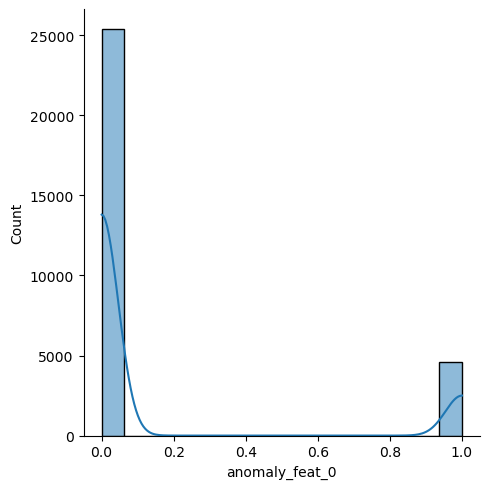

<Figure size 300x200 with 0 Axes>

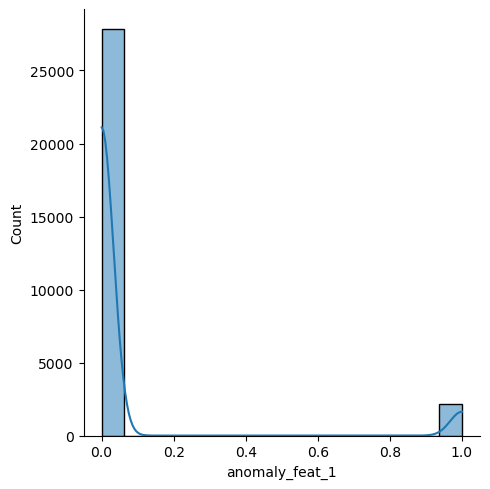

<Figure size 300x200 with 0 Axes>

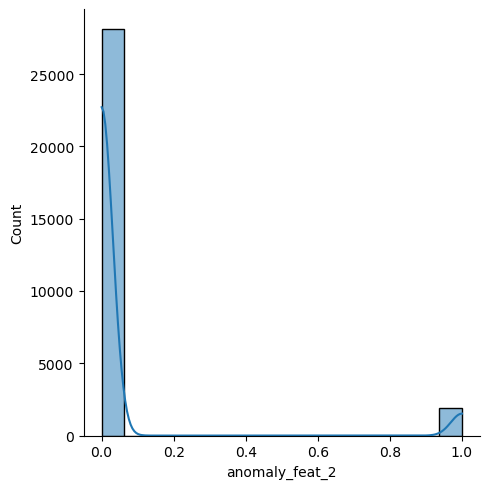

<Figure size 300x200 with 0 Axes>

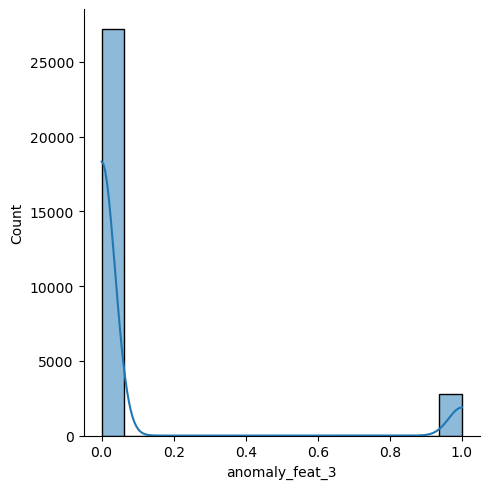

<Figure size 300x200 with 0 Axes>

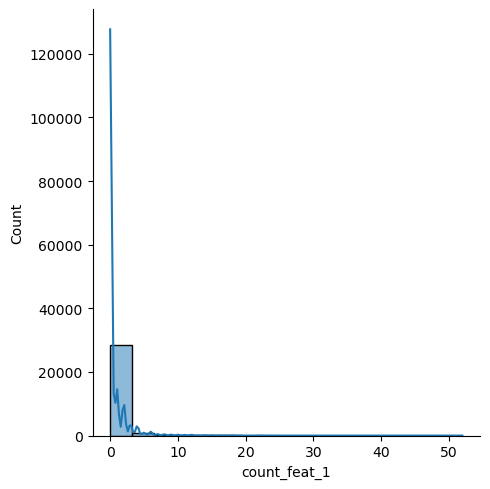

<Figure size 300x200 with 0 Axes>

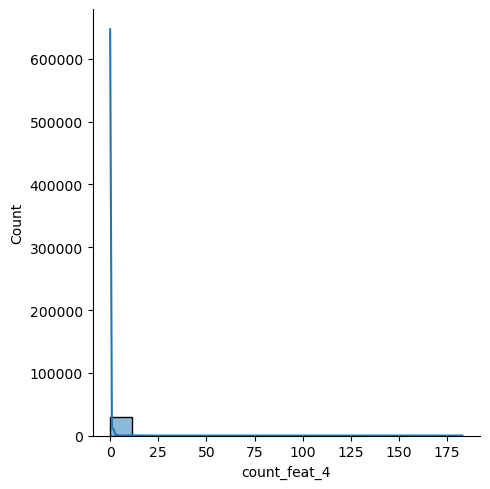

<Figure size 300x200 with 0 Axes>

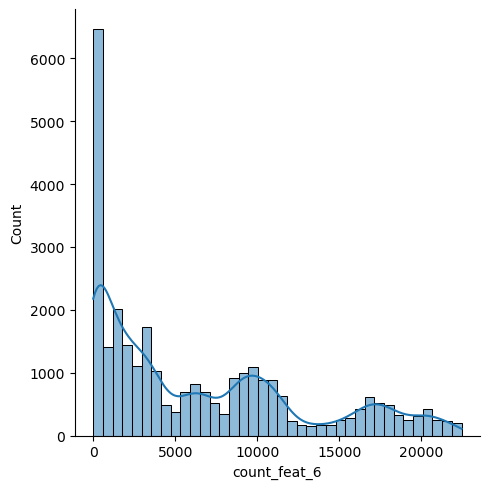

<Figure size 300x200 with 0 Axes>

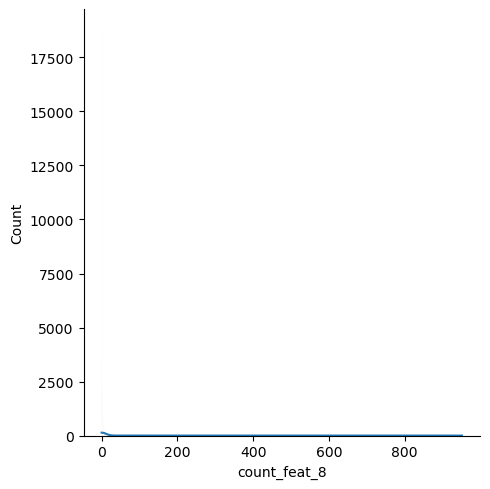

<Figure size 300x200 with 0 Axes>

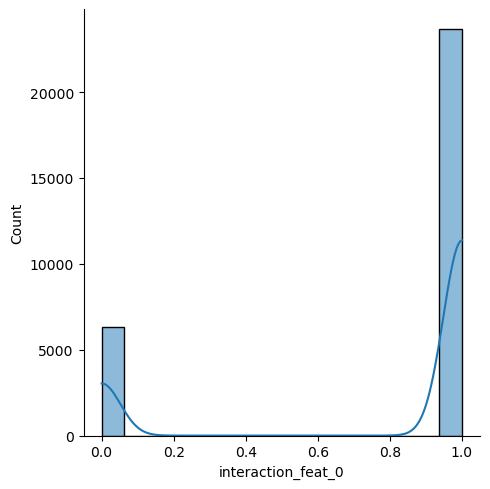

<Figure size 300x200 with 0 Axes>

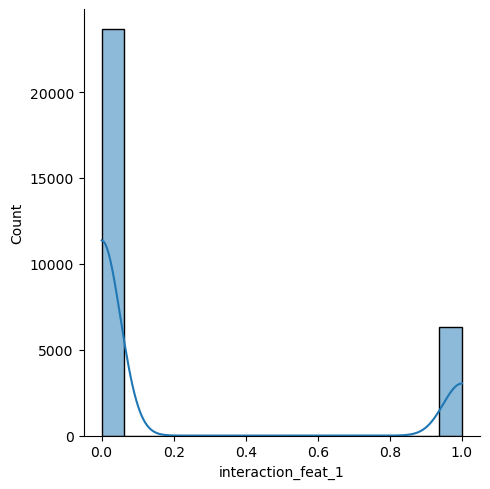

<Figure size 300x200 with 0 Axes>

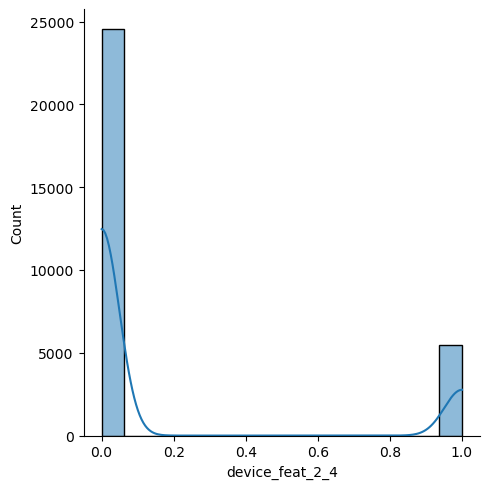

<Figure size 300x200 with 0 Axes>

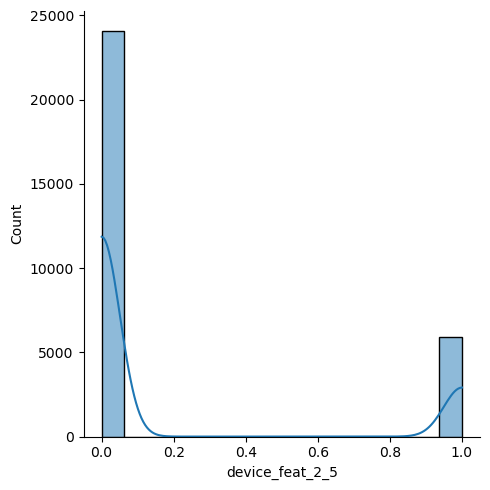

<Figure size 300x200 with 0 Axes>

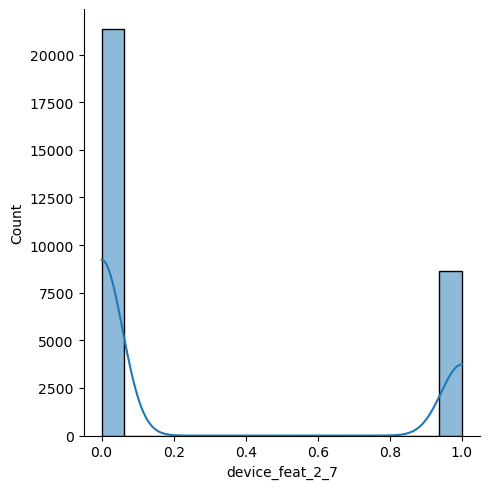

<Figure size 300x200 with 0 Axes>

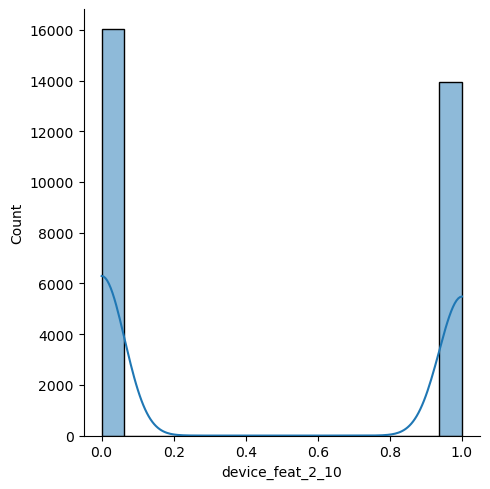

<Figure size 300x200 with 0 Axes>

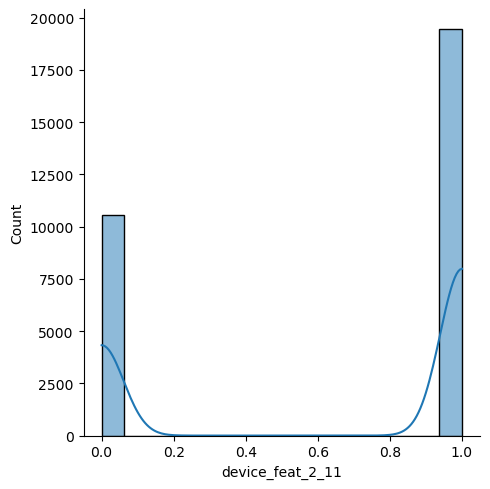

<Figure size 300x200 with 0 Axes>

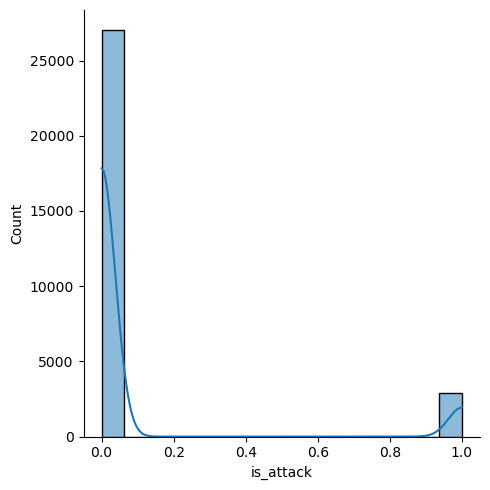

In [153]:
# Plot feature distributions
for feature in dfk.select_dtypes(include='float').columns:
    plt.figure(figsize=(3,2))
    sns.displot(dfk, x=feature, kde=True)
    plt.show()

In [169]:
t = (dff.count_feat_4 - dff.count_feat_4.mean())/dff.count_feat_4.std()

In [170]:
t.value_counts()

-0.116026      28233
 1.162285        610
 0.523130        569
 2.440597        174
 1.801441        105
 3.718908         77
 3.079752         56
 4.997219         27
 5.636375         24
 4.358063         22
 6.275530         16
 7.553841         14
 8.832153          9
 6.914686          7
 9.471308          5
 10.110464         5
 12.667086         3
 10.749620         3
 8.192997          3
 11.388775         3
 13.945398         2
 12.027931         2
 116.849452        1
 26.089354         1
 61.242913         1
 13.306242         1
Name: count_feat_4, dtype: int64

/Users/gdk/opt/anaconda3/envs/mastercard/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Axes: >

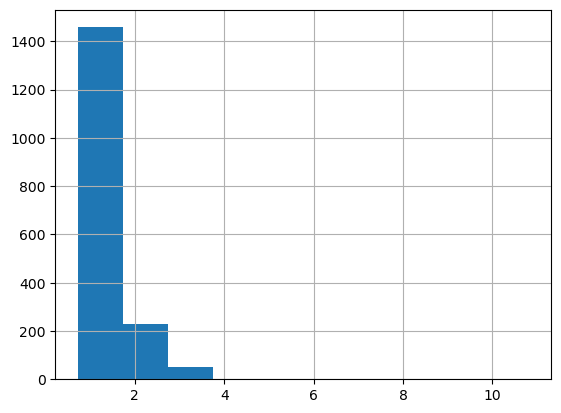

In [178]:
np.sqrt(t).hist()

In [313]:
# Scale numerical features
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
scaled_df = scaler.fit_transform(num_cols.drop('is_attack', axis=1))
scaled_df = pd.DataFrame(scaled_df, columns=num_cols.drop('is_attack', axis=1).columns)

In [315]:
scaled_df['is_attack'] = df['is_attack']

In [325]:
scaled_df.iloc[:,-8:]

count_feat_8  count_feat_9  count_feat_10  count_feat_13  \
0               0.0           1.0            3.0            0.0   
1               0.0           0.0            0.0            0.0   
2               0.0           0.0            0.0            0.0   
3               0.0           0.0            0.0            0.0   
4               3.0           0.0            0.0            0.0   
...             ...           ...            ...            ...   
29968           0.0           0.0            0.0            0.0   
29969           1.0           0.0            0.0            0.0   
29970           1.5           2.0            0.0            0.0   
29971           0.0           0.0            0.0            0.0   
29972           0.0           0.0            0.0            0.0   

       count_feat_15  interaction_feat_2  interaction_feat_3 is_attack  
0                0.0                 0.0                 0.0     False  
1                0.0                 0.0                 0.0     False  
2                0.0                 0.0                 0.0     False  
3                0.0                 0.0                 0.0     False  
4                4.0                 3.0                 0.0     False  
...              ...                 ...                 ...       ...  
29968            0.0                 0.0                 0.0     False  
29969            0.0                 1.0                 0.0     False  
29970            0.0                 0.0                 0.0     False  
29971            0.0                 0.0                 1.0     False  
29972            0.0                 0.0                 0.0     False  

[29973 rows x 8 columns]

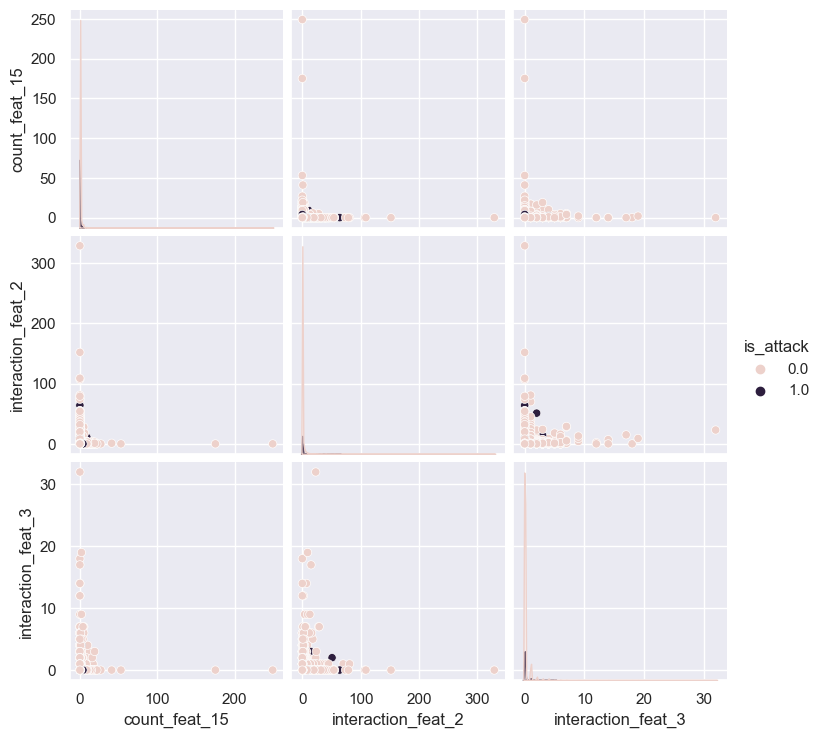

In [326]:
sns.pairplot(scaled_df.iloc[:,-4:], hue='is_attack')

<Axes: >

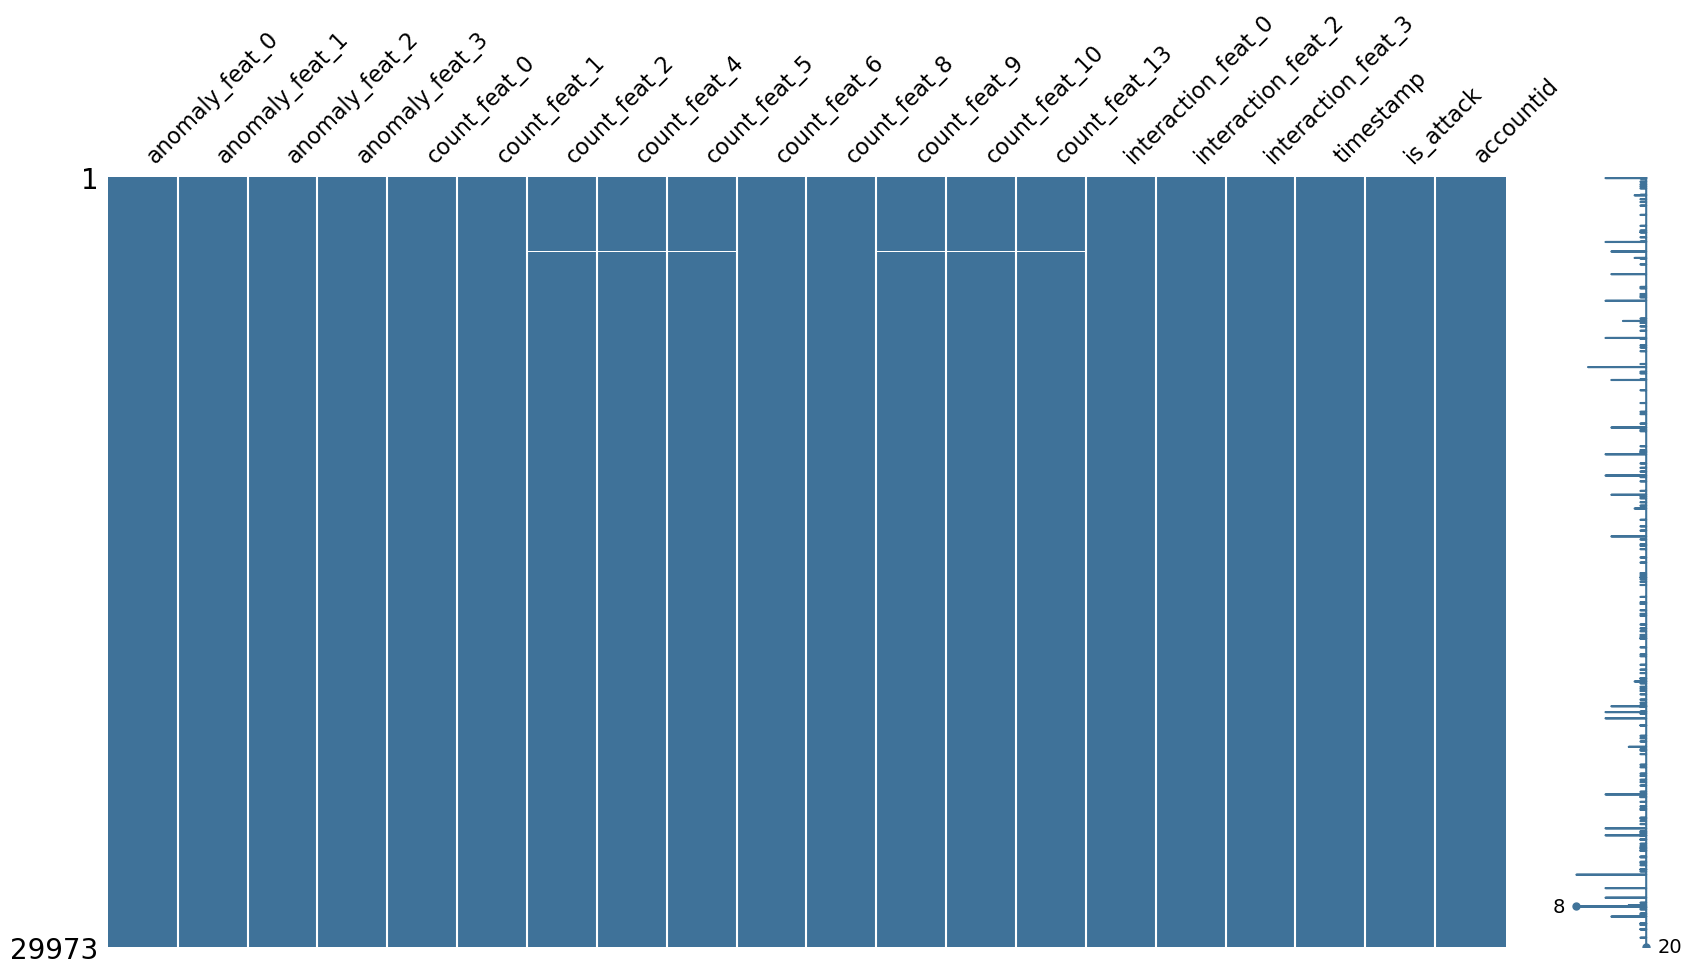

In [30]:
import missingno as msno

msno.matrix(df.drop(['device_feat_1', 'device_feat_2'], axis=1), sparkline=True, figsize=(20,10), sort=None, color=(0.25, 0.45, 0.6))

In [32]:
df.isnull().sum()

anomaly_feat_0           0
anomaly_feat_1           0
anomaly_feat_2           0
anomaly_feat_3           0
count_feat_0             4
count_feat_1             4
count_feat_2            25
count_feat_4            25
count_feat_5            12
count_feat_6           177
count_feat_8             4
count_feat_9            27
count_feat_10           27
count_feat_13           28
interaction_feat_0       0
interaction_feat_2      19
interaction_feat_3      19
timestamp                0
is_attack                0
accountid                0
device_feat_1         9075
device_feat_2         9075
dtype: int64

In [36]:
df[df['count_feat_9'].isnull()].T

23     \
anomaly_feat_0                                      True   
anomaly_feat_1                                     False   
anomaly_feat_2                                     False   
anomaly_feat_3                                     False   
count_feat_0                                         0.0   
count_feat_1                                         0.0   
count_feat_2                                         NaN   
count_feat_4                                         NaN   
count_feat_5                                         NaN   
count_feat_6                                     20417.0   
count_feat_8                                         0.0   
count_feat_9                                         NaN   
count_feat_10                                        NaN   
count_feat_13                                        NaN   
interaction_feat_0                                  True   
interaction_feat_2                                   0.0   
interaction_feat_3                                   0.0   
timestamp                                           7080   
is_attack                                          False   
accountid           9dbce609-86cf-4384-882d-b4a453d8ea1e   
device_feat_1                                 browser_15   
device_feat_2                                device_1407   

                                                   42     \
anomaly_feat_0                                      True   
anomaly_feat_1                                      True   
anomaly_feat_2                                      True   
anomaly_feat_3                                     False   
count_feat_0                                         0.0   
count_feat_1                                         0.0   
count_feat_2                                         NaN   
count_feat_4                                         NaN   
count_feat_5                                        19.0   
count_feat_6                                     11338.0   
count_feat_8                                         0.0   
count_feat_9                                         NaN   
count_feat_10                                        NaN   
count_feat_13                                        NaN   
interaction_feat_0                                  True   
interaction_feat_2                                   NaN   
interaction_feat_3                                   NaN   
timestamp                                           5645   
is_attack                                          False   
accountid           851f6226-58df-4628-9582-834840a5612a   
device_feat_1                                 browser_16   
device_feat_2                                device_4564   

                                                   2529   \
anomaly_feat_0                                     False   
anomaly_feat_1                                     False   
anomaly_feat_2                                     False   
anomaly_feat_3                                     False   
count_feat_0                                         0.0   
count_feat_1                                         0.0   
count_feat_2                                         NaN   
count_feat_4                                         NaN   
count_feat_5                                        27.0   
count_feat_6                                      8929.0   
count_feat_8                                         0.0   
count_feat_9                                         NaN   
count_feat_10                                        NaN   
count_feat_13                                        NaN   
interaction_feat_0                                  True   
interaction_feat_2                                   NaN   
interaction_feat_3                                   NaN   
timestamp                                          21230   
is_attack                                          False   
accountid           383f3ff2-e7a1-43a3-ab56-c98cb69e3f77   
device_feat_1                

In [38]:
requests_data.accountid.nunique(), device_data.accountid.nunique()

(27616, 19331)

In [65]:
df1 = df[df['count_feat_6']==0]
df2 = df[df['count_feat_6']>0]


In [63]:
df2['log_feat_1'] = np.log(df['count_feat_1'])

/Users/gdk/opt/anaconda3/envs/mastercard/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/nx/wmysyswj23sfwkb68fjfms0w0000gn/T/ipykernel_19778/2390242338.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['log_feat_1'] = np.log(df['count_feat_1'])


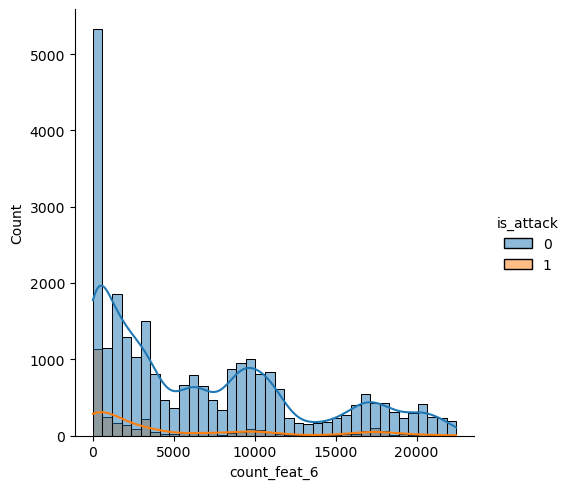

In [66]:
sns.displot(df, x='count_feat_6', hue='is_attack', kde=True)

<Axes: xlabel='is_attack', ylabel='count_feat_6'>

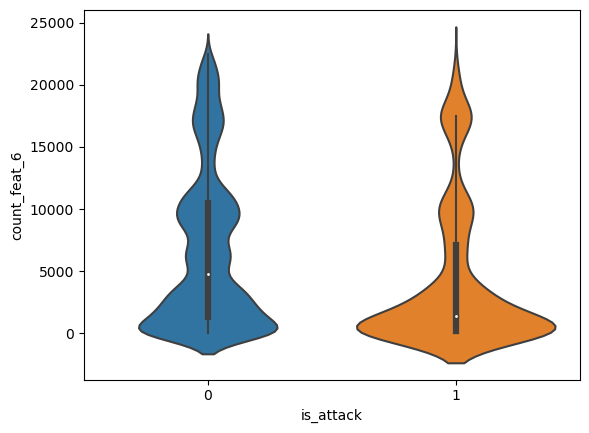

In [69]:
# Plotting box plots distribution of feature by target variable
df2.loc[df['is_attack']==False, 'is_attack'] = 0
df2.loc[df['is_attack']==True, 'is_attack'] = 1
sns.violinplot(data=df, y='count_feat_6', x='is_attack')

<Axes: xlabel='count_feat_6'>

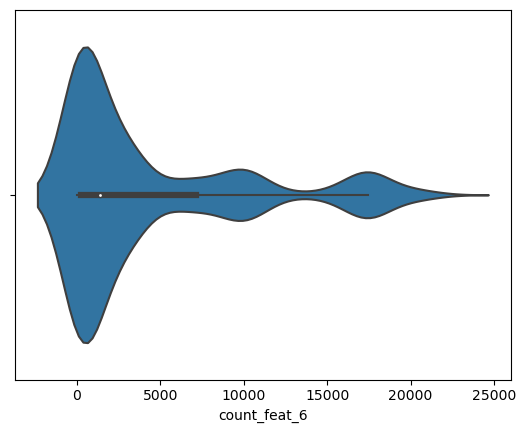

In [70]:
sns.boxplot(data=df[df['is_attack']==1], x='count_feat_6')

In [ ]:
# Feature selection in intrinsic in this case since we are using tree based models.

In [ ]:
# Implement Log Transformation to handle skew and then Standarize

## EDA

In [ ]:
# Fucntion to plot kde of all numerical features.
# Plot pairplot of selected features
# Violion plot of each num feature
# Plot value counts of reach numerical features
# Spearman coeff instead of pearson as it is robust to outliers

#  - A way to handle outliers
# Maybe binning? some call if feature hashing
# Count number of 0s in count columns, check percentage. If too high, then consider it as a sparse dataset.
Remove columns with high percentage of zeros.
Maybe lasso regulairzation - but even this is sensitive to outliers.
Cannot use PCA as PCA is sensitive to outliers. Check t-sne.

However, gradient boosting handle sparse data well.


Check Anova for categorical - device and is_attack.
Linear ression test on all features to check which are relevant and explain variance in the target variable.

At the end, plot distribition of X-train features
Pairplot of selected features

# feature selection

## Implement Sampling

#### Undersampling

#### Oversampling

#### SMOTE

# normalization

### PCA

# Models

In [ ]:
# Use class weight for XGboost

In [180]:
# KNN - also check how many clusters you see

In [311]:
# SVM

In [312]:
# Neural Net

In [179]:
# Anomaly detection - knn, svm, isolation forest

# Semi supervised learning to improve labels 

In [74]:
# import pandas as pd
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
# from sklearn.semi_supervised import LabelPropagation
# from sklearn.metrics import classification_report

# # Load and preprocess the data
# X = df.drop(['accountid', 'timestamp', 'is_attack', 'device_feat_1', 'device_feat_2'], axis=1)
# y = df['is_attack']

# # split into train and test
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, stratify=y, shuffle=True)

# # split train into labeled and unlabeled
# X_train_lab, X_test_unlab, y_train_lab, y_test_unlab = train_test_split(X_train, y_train, test_size=0.5, stratify=y_train)

# # Standardize features
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train_lab)
# X_valid_scaled = scaler.transform(X_test_unlab)
# X_unlabeled_scaled = scaler.transform(X_test)

# # Semi-Supervised Learning with Label Propagation
# lp_model = LabelPropagation(kernel='knn', n_neighbors=10)
# lp_model.fit(X_train_scaled, y_train)

# # Predict on the validation set
# y_pred_valid = lp_model.predict(X_valid_scaled)

# # Evaluate the model
# print("Classification Report for Labeled Data:")
# print(classification_report(y_valid, y_pred_valid))

# # Predict on the unlabeled data
# y_pred_unlabeled = lp_model.predict(X_unlabeled_scaled)

# # Assign pseudo-labels to the unlabeled data
# unlabeled_data['pseudo_label'] = y_pred_unlabeled

# # Combine pseudo-labeled data with labeled data
# combined_data = pd.concat([labeled_data, unlabeled_data], ignore_index=True)

# # Retrain the model on the combined dataset (including pseudo-labeled data)
# X_combined_scaled = scaler.transform(combined_data.drop(['accounted', 'is_attack', 'pseudo_label'], axis=1))
# y_combined = combined_data['is_attack']
# lp_model.fit(X_combined_scaled, y_combined)

In [77]:
# Encoding categorial variables
from category_encoders import BinaryEncoder

# Encode null device features as a separate category
df['device_feat_1'].fillna('unknown', inplace=True)
df['device_feat_2'].fillna('unknown', inplace=True)
    
encoder=BinaryEncoder(cols=['device_feat_1', 'device_feat_2'])
encoded_df = encoder.fit_transform(df[['device_feat_1', 'device_feat_2']])
dff = pd.concat([df, encoded_df], axis=1).drop(['device_feat_1', 'device_feat_2'], axis=1)

In [78]:
dff.dtypes

anomaly_feat_0          int64
anomaly_feat_1          int64
anomaly_feat_2          int64
anomaly_feat_3          int64
count_feat_0          float64
count_feat_1          float64
count_feat_2          float64
count_feat_3          float64
count_feat_4          float64
count_feat_5          float64
count_feat_6          float64
count_feat_7          float64
count_feat_8          float64
count_feat_9          float64
count_feat_10         float64
count_feat_11         float64
count_feat_12         float64
count_feat_13         float64
count_feat_14         float64
count_feat_15         float64
interaction_feat_0      int64
interaction_feat_1      int64
interaction_feat_2    float64
interaction_feat_3    float64
timestamp               int64
is_attack               int64
accountid              object
device_feat_1_0         int64
device_feat_1_1         int64
device_feat_1_2         int64
device_feat_1_3         int64
device_feat_1_4         int64
device_feat_2_0         int64
device_fea

In [227]:
# Handling outliers 
# Try isolation forest to identify outliers
from sklearn.model_selection import train_test_split
X = dff.drop(['timestamp', 'accountid', 'is_attack'], axis=1)
y = dff['is_attack']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [228]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((20981, 42), (8992, 42), (20981,), (8992,))

In [229]:
X_train = handle_nulls(X_train)
X_test = handle_nulls(X_test)

In [230]:
X = handle_nulls(X)

In [276]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=20)
X_pca = pca.fit_transform(X_scaled)

In [277]:
# Calculate the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Calculate the cumulative explained variance
cumulative_variance = np.cumsum(explained_variance_ratio)


In [278]:
cumulative_variance

array([0.12948737, 0.23288852, 0.32637233, 0.40219629, 0.46805931,
       0.51326964, 0.54640522, 0.57567381, 0.60391551, 0.62975876,
       0.65407443, 0.6780725 , 0.70150304, 0.72449803, 0.74621768,
       0.76692889, 0.78566738, 0.80378352, 0.82141836, 0.83832062])

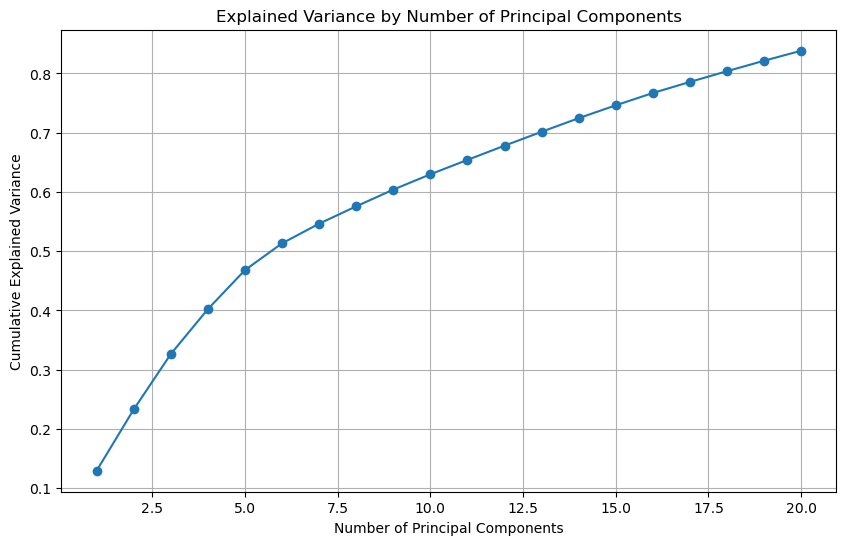

In [279]:
# Plot the explained variance
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.title('Explained Variance by Number of Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

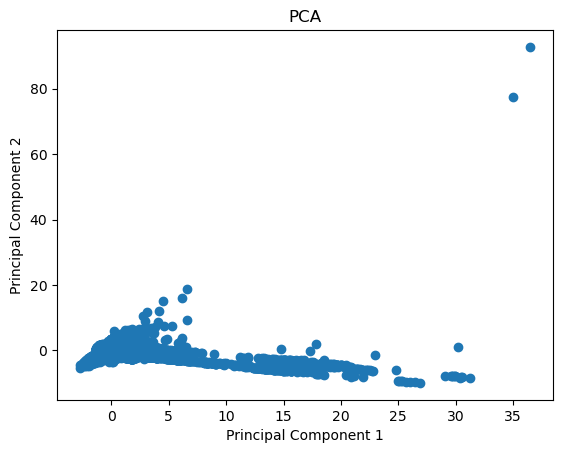

In [280]:
plt.scatter(X_pca[:,0], X_pca[:,1])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA')
plt.show()

In [285]:
from sklearn.ensemble import IsolationForest

clf = IsolationForest()
clf.fit(X)
dff['is_anomaly'] = clf.predict(X)
anomaly_labels = clf.predict(X)

In [286]:
dff.is_anomaly.value_counts()

 1    27401
-1     2572
Name: is_anomaly, dtype: int64

In [287]:
len(anomaly_labels[anomaly_labels==-1])

2572

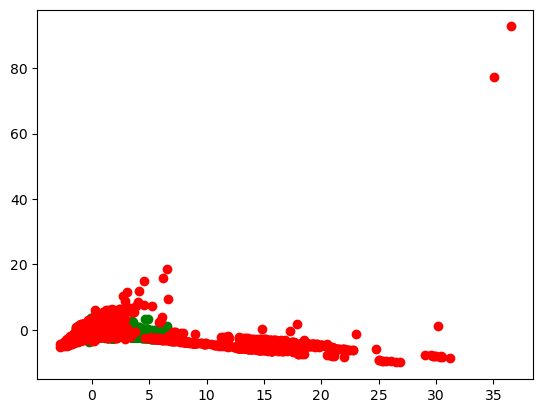

In [288]:
# Visualize anomalies using scatter plot
plt.scatter(X_pca[anomaly_labels == 1][:, 0], X_pca[anomaly_labels == 1][:, 1], color='green', label='Normal')
plt.scatter(X_pca[anomaly_labels == -1][:, 0], X_pca[anomaly_labels == -1][:, 1], color='red', label='Anomaly')

In [292]:
from sklearn.svm import OneClassSVM
# Alternatively, use One-Class SVM
model_one_class_svm = OneClassSVM(nu=0.01)
model_one_class_svm.fit(X_pca)
anomaly_labels_svm = model_one_class_svm.predict(X_pca)

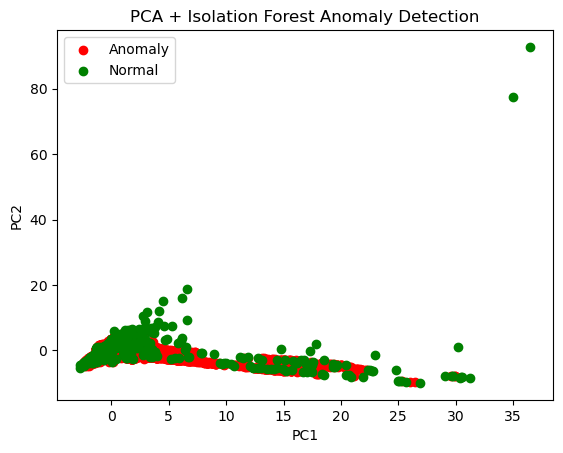

In [293]:
# Visualize anomalies using scatter plot
plt.scatter(X_pca[anomaly_labels_svm == 1][:, 0], X_pca[anomaly_labels_svm == 1][:, 1], color='red', label='Anomaly')
plt.scatter(X_pca[anomaly_labels_svm == -1][:, 0], X_pca[anomaly_labels_svm == -1][:, 1], color='green', label='Normal')
plt.title('PCA + Isolation Forest Anomaly Detection')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.show()

<Axes: xlabel='count_feat_1', ylabel='count_feat_2'>

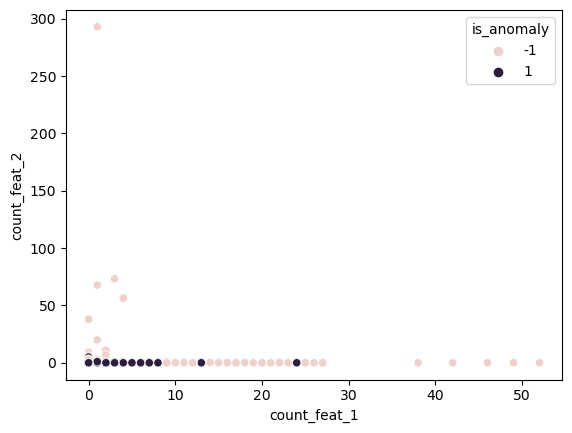

In [290]:
sns.scatterplot(dff, x='count_feat_1', y='count_feat_2', hue='is_anomaly')

In [291]:
dff

anomaly_feat_0  anomaly_feat_1  anomaly_feat_2  anomaly_feat_3  \
0                   1               0               0               0   
1                   0               0               0               0   
2                   0               0               0               0   
3                   0               0               0               0   
4                   0               0               0               0   
...               ...             ...             ...             ...   
30007               0               0               0               0   
30008               0               0               0               0   
30009               0               0               0               0   
30010               0               0               0               0   
30011               0               0               0               0   

       count_feat_0  count_feat_1  count_feat_2  count_feat_3  count_feat_4  \
0               0.0           0.0          0.00           0.0           0.0   
1               0.0           0.0          0.00           0.0           0.0   
2               0.0           0.0          0.00           0.0           0.0   
3               0.0           0.0          0.00           0.0           0.0   
4               0.0           4.0          0.25           3.0           4.0   
...             ...           ...           ...           ...           ...   
30007           0.0           0.0          0.00           0.0           0.0   
30008           0.0           0.0          0.00           0.0           0.0   
30009           0.0           3.0          0.00           2.0           0.0   
30010           0.0           0.0          0.00           0.0           0.0   
30011           0.0           0.0          0.00           0.0           0.0   

       count_feat_5  ...  device_feat_2_4  device_feat_2_5  device_feat_2_6  \
0               0.0  ...                0                0                0   
1              32.0  ...                0                0                0   
2               2.0  ...                0                0                0   
3               2.0  ...                0                0                0   
4               0.0  ...                0                0                0   
...             ...  ...              ...              ...              ...   
30007           0.0  ...                0                0                0   
30008           3.0  ...                0                0                0   
30009           0.0  ...                1                1                1   
30010           1.0  ...                0                0                0   
30011           0.0  ...                0                1                1   

       device_feat_2_7  device_feat_2_8  device_feat_2_9  device_feat_2_10  \
0                    0                0                0                 0   
1                    0                0                0                 0   
2                    0                0                0                 0   
3                    0                0                0                 0   
4                    0                0                0                 0   
...                ...              ...              ...               ...   
30007                0                0                1                 0   
30008                0                0                0                 0   
30009                1                1                1                 1   
30010                0                0                0                 0   
30011                0                1                0                 1   

       device_feat_2_11  device_feat_2_12  is_anomaly  
0                     0                 1           1  
1                     1                 0           1  
2                     1                 1           1  
3                     1                 1           1  
4              

/Users/gdk/opt/anaconda3/envs/mastercard/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/gdk/opt/anaconda3/envs/mastercard/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/mod

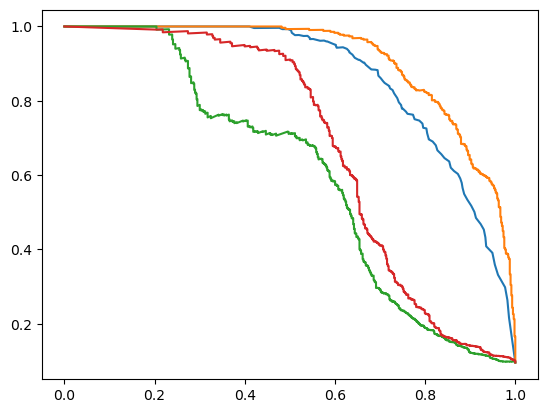

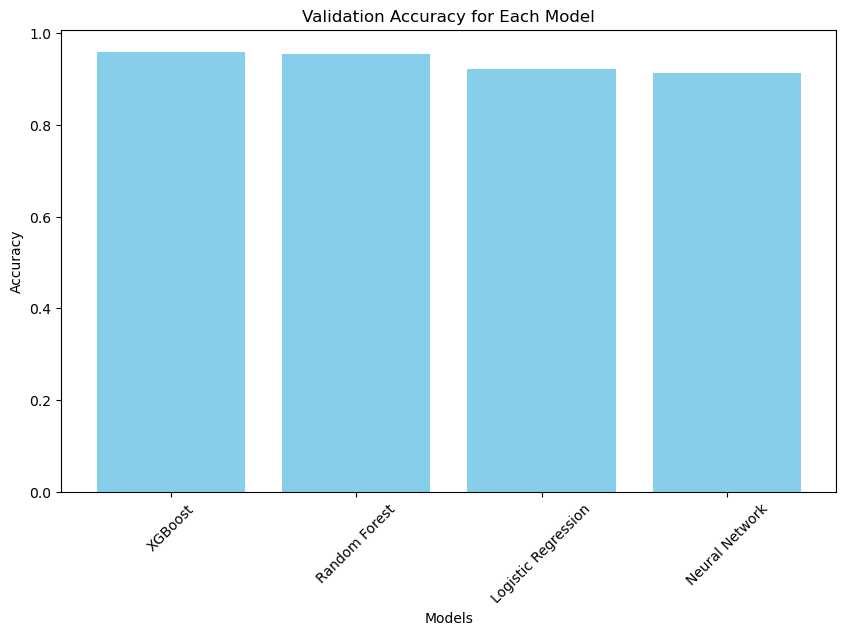

Best Model: XGBoost


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


              precision    recall  f1-score   support

           0       0.97      0.99      0.98      5422
           1       0.88      0.75      0.81       573

    accuracy                           0.97      5995
   macro avg       0.93      0.87      0.89      5995
weighted avg       0.96      0.97      0.96      5995



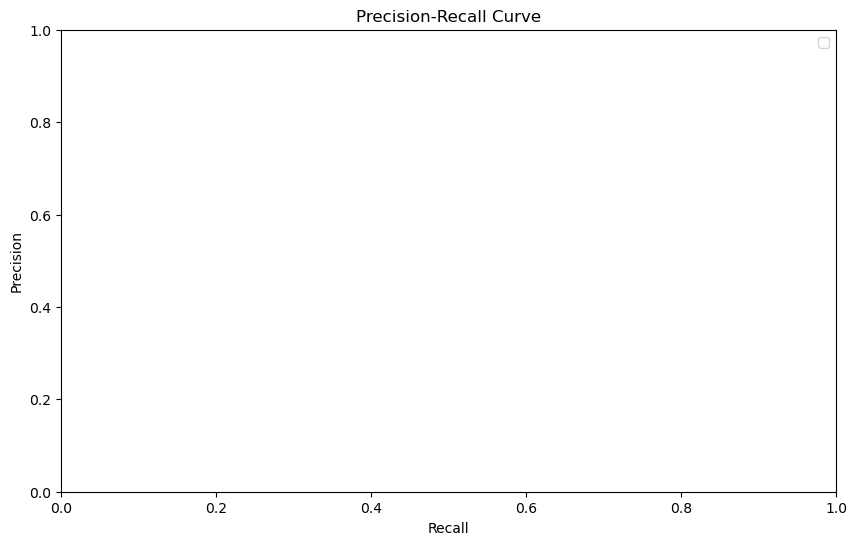

In [297]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, precision_recall_curve, auc

def classification_pipeline(data):
    X = data.drop(['timestamp', 'accountid', 'is_attack'], axis=1)
    y = data['is_attack']
    
    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Create a dictionary to store models
    models = {
        'Random Forest': RandomForestClassifier(),
        'XGBoost': XGBClassifier(),
        'Logistic Regression': LogisticRegression(),
        'Neural Network': MLPClassifier()
    }
    
    # Initialize lists to store accuracy and pr-auc
    accuracy_scores = []
    pr_auc_scores = []
    
    # Loop through each model
    for model_name, model in models.items():
        # Perform cross-validation
        accuracy = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
        accuracy_scores.append((model_name, np.mean(accuracy)))
        
        # Fit the model on the full training set
        model.fit(X_train, y_train)
        
        # Predict probabilities on the test set
        y_probs = model.predict_proba(X_test)[:, 1]
        
        # Calculate precision-recall curve values
        precision, recall, _ = precision_recall_curve(y_test, y_probs)
        pr_auc = auc(recall, precision)
        pr_auc_scores.append((model_name, pr_auc))
        
        # Plot PR-curve
        plt.plot(recall, precision, label=f'{model_name} (AUC = {pr_auc:.2f})')

    # Plot accuracy scores
    accuracy_scores.sort(key=lambda x: x[1], reverse=True)
    best_model_name, _ = accuracy_scores[0]
    
    plt.figure(figsize=(10, 6))
    for model_name, accuracy in accuracy_scores:
        plt.bar(model_name, accuracy, color='skyblue')
    plt.xlabel('Models')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy for Each Model')
    plt.xticks(rotation=45)
    plt.show()
    
    # Print best model
    print(f'Best Model: {best_model_name}')
    
    # Print classification report for the best model
    best_model = models[best_model_name]
    best_model.fit(X_train, y_train)
    y_pred = best_model.predict(X_test)
    print(classification_report(y_test, y_pred))
    
    # Plot PR-curve for the best model
    plt.figure(figsize=(10, 6))
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.show()

classification_pipeline(dff)